<a href="https://colab.research.google.com/github/ChanZH0525/WOA-7015-AA/blob/main/Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import json
import zipfile
import copy

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import files

**Data Uploading**

We upload two primary components: the VQA-RAD dataset metadata (.json) and the image repository (.zip). This is because the hosting URLs provided in the metadata for images are no longer accessible. By manually uploading and extracting the images to a directory, we ensure stable and low-latency access during the model training phase.

In [ ]:
file_dataset = 'VQA_RAD Dataset Public.json'
file_image = 'VQA_RAD Image.zip'

print("Please upload 'VQA_RAD Dataset Public.json'\n")
uploaded_1 = files.upload()

# Load JSON into DataFrame to avoid some unnecessary coding work later
with open(file_dataset, 'r') as f:
    dataset = json.load(f)
df_dataset = pd.DataFrame(dataset)
print("\nThe dataset is uploaded.\n")

print("Next, please upload 'VQA_RAD Image.zip'\n")
uploaded_2 = files.upload()

# Create a clean folder to store the images of VQA-RAD
image_folder = '/content/VQA_RAD_Image'

# Unzip 'VQA_RAD Image.zip' into image_folder
with zipfile.ZipFile(file_image, 'r') as z:
    z.extractall(image_folder)
print(f"\nThe images are uploaded and extracted at {image_folder}")

Please upload 'VQA_RAD Dataset Public.json'



Saving VQA_RAD Dataset Public.json to VQA_RAD Dataset Public.json

The dataset is uploaded.

Next, please upload 'VQA_RAD Image.zip'



Saving VQA_RAD Image.zip to VQA_RAD Image.zip

The images are uploaded and extracted at /content/VQA_RAD_Image


**Data Linking & Verification**

We implement a linker function to map each sample to its corresponding image file on Google Colab. A verification step confirms the existence of every image path to prevent runtime errors.

In [ ]:
# Create the linker
def get_image_path(imagename):

    # Construct the full image path (e.g., /content/VQA_RAD_Image/synpic676.jpg)
    full_path = os.path.join(image_folder, imagename)

    # Check whether the file exists or not
    if os.path.exists(full_path):
        return full_path
    else:
        return None

# Apply the linker
# This creates a new column 'image_path' with the exact address of the file
df_dataset['image_path'] = df_dataset['image_name'].apply(get_image_path)

# Filter out None values in 'image_path' column
df_full_dataset = df_dataset.dropna(subset=['image_path'])

# Verify whether the dataset is fully linked with the images or not
print(f"Total Samples: {len(df_dataset)}")
print(f"Valid Linked Images: {len(df_full_dataset)}\n")

if len(df_full_dataset) == len(df_dataset):
    print("SUCCESS! The linking is successful, hence data integrity is 100%.")
else:
    print(f"WARNING! The linking is unsuccessful due to {len(df_dataset) - len(df_full_dataset)} missing images.")

Total Samples: 2248
Valid Linked Images: 2248

SUCCESS! The linking is successful, hence data integrity is 100%.


**Data Cleaning: Integrity Check and Deduplication**

Following the analysis by [Giammarino](https://huggingface.co/datasets/flaviagiammarino/vqa-rad), we identified quality issues in the original dataset published by [Lau et al.](https://osf.io/89kps/files). Specifically:

1. Image Utilization: The dataset contains 315 images, but only 314 are referenced by the 2,248 question-answer pairs. One image file is extraneous and not used.

2. Redundancy: The training set contains 3 duplicate triplets (Image + Question + Answer).

3. Data Leakage: There is 1 triplet in the training set that also appears in the test set.

To ensure rigorous evaluation, we implemented a cleaning pipeline to handle these discrepancies, resulting in a final validated dataset of 2,244 samples linked to 314 unique images.

In [ ]:
print("Checking total number of referenced images:")
# Verify the number of referenced images
num_refer_images = df_full_dataset['image_path'].nunique()
if num_refer_images == 314:
    print(f"Only {num_refer_images} referenced image(s) are found in VQA-RAD, hence Giammarino is right.")
    print("No action needed, since the extra image is excluded from the dataframe index.")
    print("The data loader will automatically ignore it, so the deletion is not required.\n")
else:
    print(f"Only {num_refer_images} referenced image(s) are found")
    print("No action needed, since the extra image is excluded from the dataframe index.")
    print("The data loader will automatically ignore it, so the deletion is not required.\n")

print("Checking total number of duplicates and leakages in training set:")
# According to the paper and Readme written by Lau et al.:
# Test set = phrase_type contains 'test_freeform' or 'test_para'
# Training set = the remainder of phrase_type
# Define split based on the logic above
def get_split(phrase_type):
    if 'test' in str(phrase_type).lower():
        return 'Test'
    return 'Train'

# Create a new column 'split' that would be used for the formation of training/test set in later
df_full_dataset['split'] = df_full_dataset['phrase_type'].apply(get_split)

# Normalize question and answer to ensure the duplicates and common are detected accurately
# Image name is not included since it is already verified in previous block (linker)
df_full_dataset['question'] = df_full_dataset['question'].astype(str).str.lower().str.strip().str.replace("?", "")
df_full_dataset['answer'] = df_full_dataset['answer'].astype(str).str.lower().str.strip()

# Find duplicates in training set
# by looking for rows where Image + Normalized Question + Normalized Answer are identical
cols_check = ['image_name', 'question', 'answer']
train_mask = df_full_dataset['split'] == 'Train'
duplicates = df_full_dataset[train_mask].duplicated(subset=cols_check, keep='first')

if duplicates.sum() > 0:
    print(f"Found {duplicates.sum()} duplicate(s). Cleaning them...")
    df_clean_dataset = df_full_dataset.drop(df_full_dataset[train_mask][duplicates].index)
else:
    print("No duplicates found.")
    df_clean_dataset = df_full_dataset.copy()

# Find leakage in training set
# by checking if any (Image + Normalized Question + Normalized Answer) in training set also exists in test set
train_data = df_clean_dataset[df_clean_dataset['split'] == 'Train'].copy()
test_data = df_clean_dataset[df_clean_dataset['split'] == 'Test'].copy()

leakage = pd.merge(train_data, test_data, on=cols_check, how='inner')

if len(leakage) > 0:
    print(f"Found {len(leakage)} leakage(s). Cleaning them...\n")

    # Iterate through leakage to remove the specific rows with 'Train'
    # Iterrows is used in case there is more than 1, though Giammarino says 1
    for i, row in leakage.iterrows():
        # Find the index in the clean dataset that matches the leak
        leak_index = df_clean_dataset[
            (df_clean_dataset['split'] == 'Train') &
            (df_clean_dataset['image_name'] == row['image_name']) &
            (df_clean_dataset['question'] == row['question']) &
            (df_clean_dataset['answer'] == row['answer'])
        ].index

        df_clean_dataset = df_clean_dataset.drop(leak_index)

    df_final_dataset = df_clean_dataset.copy()
else:
    print("No leakage found.\n")
    df_final_dataset = df_clean_dataset.copy()

print("The result:")
# Verify the labels for a final checking
print(f"Original Samples in VQA-RAD: {len(df_full_dataset)}")
print(f"Final Samples in VQA-RAD:    {len(df_final_dataset)}")

if len(df_final_dataset) == 2244:
    print("SUCCESS! The duplicate(s) and leakage(s) are removed from training set, hence Giammarino is right")
else:
    print("SUCCESS! The duplicate(s) and leakage(s) are removed from training set")

Checking total number of referenced images:
Only 314 referenced image(s) are found in VQA-RAD, hence Giammarino is right.
No action needed, since the extra image is excluded from the dataframe index.
The data loader will automatically ignore it, so the deletion is not required.

Checking total number of duplicates and leakages in training set:
Found 3 duplicate(s). Cleaning them...
Found 1 leakage(s). Cleaning them...

The result:
Original Samples in VQA-RAD: 2248
Final Samples in VQA-RAD:    2244
SUCCESS! The duplicate(s) and leakage(s) are removed from training set, hence Giammarino is right


Simple Exploratory Data Analysis (EDA)

In [ ]:
print("DATA QUALITY AUDIT\n")

# Look at columns that should have not repeated categories
# Logic analogy: If "HEAD" and "head" are found, that's a mistake
print("Step 1: Spotting Inconsistencies\n")

print("[1] Checking 'image_organ' consistency:\n")
print(f"Category: {df_final_dataset['image_organ'].unique().tolist()}\n")
print(df_final_dataset['image_organ'].value_counts())
print("-" * 40)

print("\n[2] Checking 'question_type' consistency:\n")
print(f"Category: {df_final_dataset['question_type'].unique().tolist()}\n")
print(df_final_dataset['question_type'].value_counts())
print("-" * 40)

print("\n[3] Checking 'answer_type' consistency:\n")
print(f"Category: {df_final_dataset['answer_type'].unique().tolist()}\n")
print(df_final_dataset['answer_type'].value_counts())
print("-" * 40)

# Remember that phrase_type is used for train/test split (Lau et al.'s logic)
# Just want to ensure these look correct and aren't mixed up
print("\n[4] Checking 'phrase_type' consistency:\n")
print(f"Category: {df_final_dataset['phrase_type'].unique().tolist()}\n")
print(df_final_dataset['phrase_type'].value_counts())
print("-" * 40)

# Find missing values in the dataset
print("\nStep 2: Spotting Missing Values\n")
print("[5] Checking for missing values:")
print(df_final_dataset.isnull().sum())

DATA QUALITY AUDIT

Step 1: Spotting Inconsistencies

[1] Checking 'image_organ' consistency:

Category: ['HEAD', 'CHEST', 'ABD']

image_organ
CHEST    791
ABD      739
HEAD     714
Name: count, dtype: int64
----------------------------------------

[2] Checking 'question_type' consistency:

Category: ['PRES', 'ABN', 'MODALITY', 'ORGAN', 'POS', 'PLANE', 'OTHER', 'SIZE, PRES', 'SIZE', 'COUNT', 'ATTRIB', 'ATTRIB, SIZE', 'PRES, ABN', 'COLOR', 'PRES, POS', 'ATTRIB, PRES', 'Other', 'COLOR, PRES', 'POS, PRES', 'PRES, ATTRIB', 'POS, ABN', 'ABN, POS', 'SIZE, COLOR', 'PRES, COLOR', 'ATRIB', 'PRSE']

question_type
PRES            800
POS             314
ABN             201
OTHER           194
MODALITY        185
SIZE            170
PLANE           120
ATTRIB           87
ORGAN            59
COLOR            52
COUNT            24
PRES, ATTRIB      6
POS, PRES         6
ATTRIB, PRES      4
PRES, POS         4
ABN, POS          3
SIZE, PRES        2
Other             2
SIZE, COLOR       2
POS, ABN

In [ ]:
print("DATA QUALITY FIXING\n")
print("Fixing inconsistencies in Step 1 of Data Quality Audit:")

# Fix 1: The typos and ordering in question_type
# Define a correction dictionary for typos and apply it
typo_corrections = {
    'Other': 'OTHER',
    'ATRIB': 'ATTRIB',
    'PRSE': 'PRES'
}
df_final_dataset['question_type'] = df_final_dataset['question_type'].replace(typo_corrections)

# Fix the ordering (e.g., "PRES, ATTRIB" vs "ATTRIB, PRES")
# Logic: Split the string by comma, sort the words alphabetically, and join them back.
# Result: Both become "ATTRIB, PRES"
def normalize_multilabel(label):
    if ',' in str(label):
        parts = [p.strip() for p in str(label).split(',')]
        parts.sort()
        return ", ".join(parts)
    return label

df_final_dataset['question_type'] = df_final_dataset['question_type'].apply(normalize_multilabel)
print("SUCCESS! 'question_type' typos and ordering fixed.")

# Fix 2: The whitespace in answer_type
# Strip whitespace at the end
df_final_dataset['answer_type'] = df_final_dataset['answer_type'].str.strip()
print("SUCCESS! 'answer_type' whitespace removed.\n")

print("Filling missing values in Step 2 of Data Quality Audit:")
# Fill missing values with 'None'
df_final_dataset['question_rephrase'] = df_final_dataset['question_rephrase'].fillna("None")
print("SUCCESS! Missing values in 'question_rephrase' filled with 'None'.")
print("However, why does filling instead of removing?")
print("Reason: We follow the 'Data Conservation' principle.")
print("Explanation: Dropping rows with missing 'question_rephrase' would unnecessarily discard valid Image-Question-Answer training samples.")

DATA QUALITY FIXING

Fixing inconsistencies in Step 1 of Data Quality Audit:
SUCCESS! 'question_type' typos and ordering fixed.
SUCCESS! 'answer_type' whitespace removed.

Filling missing values in Step 2 of Data Quality Audit:
SUCCESS! Missing values in 'question_rephrase' filled with 'None'.
However, why does filling instead of removing?
Reason: We follow the 'Data Conservation' principle.
Explanation: Dropping rows with missing 'question_rephrase' would unnecessarily discard valid Image-Question-Answer training samples.


Re-EDA

In [ ]:
print("DATA QUALITY AUDIT\n")

# Look at columns that should have not repeated categories
# Logic analogy: If "HEAD" and "head" are found, that's a mistake
print("Step 1: Spotting Inconsistencies\n")

print("[1] Checking 'image_organ' consistency:\n")
print(f"Category: {df_final_dataset['image_organ'].unique().tolist()}\n")
print(df_final_dataset['image_organ'].value_counts())
print("-" * 40)

print("\n[2] Checking 'question_type' consistency:\n")
print(f"Category: {df_final_dataset['question_type'].unique().tolist()}\n")
print(df_final_dataset['question_type'].value_counts())
print("-" * 40)

print("\n[3] Checking 'answer_type' consistency:\n")
print(f"Category: {df_final_dataset['answer_type'].unique().tolist()}\n")
print(df_final_dataset['answer_type'].value_counts())
print("-" * 40)

# Remember that phrase_type is used for train/test split (Lau et al.'s logic)
# Just want to ensure these look correct and aren't mixed up
print("\n[4] Checking 'phrase_type' consistency:\n")
print(f"Category: {df_final_dataset['phrase_type'].unique().tolist()}\n")
print(df_final_dataset['phrase_type'].value_counts())
print("-" * 40)

# Find missing values in the dataset
print("\nStep 2: Spotting Missing Values\n")
print("[5] Checking for missing values:")
print(df_final_dataset.isnull().sum())

DATA QUALITY AUDIT

Step 1: Spotting Inconsistencies

[1] Checking 'image_organ' consistency:

Category: ['HEAD', 'CHEST', 'ABD']

image_organ
CHEST    791
ABD      739
HEAD     714
Name: count, dtype: int64
----------------------------------------

[2] Checking 'question_type' consistency:

Category: ['PRES', 'ABN', 'MODALITY', 'ORGAN', 'POS', 'PLANE', 'OTHER', 'PRES, SIZE', 'SIZE', 'COUNT', 'ATTRIB', 'ATTRIB, SIZE', 'ABN, PRES', 'COLOR', 'POS, PRES', 'ATTRIB, PRES', 'COLOR, PRES', 'ABN, POS', 'COLOR, SIZE']

question_type
PRES            801
POS             314
ABN             201
OTHER           196
MODALITY        185
SIZE            170
PLANE           120
ATTRIB           88
ORGAN            59
COLOR            52
COUNT            24
ATTRIB, PRES     10
POS, PRES        10
ABN, POS          5
COLOR, PRES       3
PRES, SIZE        2
COLOR, SIZE       2
ATTRIB, SIZE      1
ABN, PRES         1
Name: count, dtype: int64
----------------------------------------

[3] Checking 'answer_t

---

## 🔍 Data Quality Investigation

**Purpose:** Systematic identification of all quality issues before preprocessing

This integrated analysis combines:
- Answer column quality checks
- Question column quality checks
- Special character detection
- Spelling and formatting issues

Results inform preprocessing decisions in the next section.

In [ ]:
import re
import string
from collections import defaultdict, Counter
import pandas as pd

print("="*80)
print("COMPREHENSIVE DATA QUALITY INVESTIGATION")
print("="*80)

print(f"\nAnalyzing {len(df_final_dataset)} samples...")
print(f"Current unique answers: {df_final_dataset['answer'].nunique()}")
print(f"Current unique questions: {df_final_dataset['question'].nunique()}")

# ============================================================================
# ISSUE 1: SEPARATOR & SPECIAL CHARACTER ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("ISSUE 1: SEPARATOR & SPECIAL CHARACTER ANALYSIS")
print("="*80)

print("\n[Data-Driven Discovery: Finding ALL special characters in dataset]")

# Discover all special characters in answers
answer_special_chars = set()
for answer in df_final_dataset['answer']:
    for char in str(answer):
        if char not in string.ascii_letters and char not in string.digits and char != ' ':
            answer_special_chars.add(char)

# Discover all special characters in questions
question_special_chars = set()
for question in df_final_dataset['question']:
    for char in str(question):
        if char not in string.ascii_letters and char not in string.digits and char != ' ':
            question_special_chars.add(char)

all_special_chars = sorted(answer_special_chars.union(question_special_chars))

print(f"\nSpecial characters found: {len(all_special_chars)}")
print(f"In answers only: {sorted(answer_special_chars - question_special_chars)}")
print(f"In questions only: {sorted(question_special_chars - answer_special_chars)}")
print(f"In both: {sorted(answer_special_chars.intersection(question_special_chars))}")

# Categorize special characters
def categorize_char(char):
    if char in '-–—_':
        return 'Separator'
    elif char in '/\\|':
        return 'Separator'
    elif char in '.,;:!?':
        return 'Punctuation'
    elif char in '()[]{}':
        return 'Bracket'
    elif char in '\'\"':
        return 'Quote'
    elif char in '+×÷=<>':
        return 'Mathematical'
    elif char in '&%$#@':
        return 'Symbol'
    elif char in '\t\n\r':
        return 'Whitespace'
    else:
        return 'Other'

# Create structured table
print("\n" + "═"*100)
print("STRUCTURED REPORT: Special Characters")
print("═"*100)
print(f"{'Character':<12} {'Category':<15} {'In Answers':<12} {'In Questions':<13} {'Examples':<30}")
print("─"*100)

for char in all_special_chars:
    category = categorize_char(char)

    # Count occurrences
    count_ans = df_final_dataset['answer'].str.contains(re.escape(char), regex=True, na=False).sum()
    count_ques = df_final_dataset['question'].str.contains(re.escape(char), regex=True, na=False).sum()

    # Get examples from answers first, then questions if no answers
    if count_ans > 0:
        examples = df_final_dataset[df_final_dataset['answer'].str.contains(
            re.escape(char), regex=True, na=False)]['answer'].unique()[:2]
        example_str = str(list(examples)[:2])[1:-1][:28]
    elif count_ques > 0:
        # If no examples in answers, get from questions
        examples = df_final_dataset[df_final_dataset['question'].str.contains(
            re.escape(char), regex=True, na=False)]['question'].unique()[:2]
        example_str = str(list(examples)[:2])[1:-1][:28]
    else:
        example_str = ""

    # Display character (handle special cases)
    if char == '\t':
        char_display = '\\t (TAB)'
    elif char == '\n':
        char_display = '\\n (LF)'
    elif char == '\r':
        char_display = '\\r (CR)'
    else:
        char_display = f"'{char}'"

    print(f"{char_display:<12} {category:<15} {count_ans:<12} {count_ques:<13} {example_str:<30}")

print("═"*100)

# Analyze separator variants
print("\n[Separator Variant Analysis]")
print("-"*80)

def normalize_separators_all(text):
    # Remove ALL separators to get just alphanumeric content
    return re.sub(r'[-–—_/\\|\s]+', ' ', str(text)).strip().lower()

# Check ANSWERS for separator variants
print("\n[A] SEPARATOR VARIANTS IN ANSWERS")
content_groups_ans = defaultdict(list)
for answer in df_final_dataset['answer'].unique():
    normalized = normalize_separators_all(answer)
    if normalized:  # Skip empty
        content_groups_ans[normalized].append(answer)

variant_groups_ans = {k: v for k, v in content_groups_ans.items() if len(v) > 1}

print(f"\nFound {len(variant_groups_ans)} answer groups with separator variants")

if len(variant_groups_ans) > 0:
    print("\nTop 5 examples:")
    for normalized_content, variants in list(variant_groups_ans.items())[:5]:
        counts = [df_final_dataset[df_final_dataset['answer'] == v].shape[0] for v in variants]
        total = sum(counts)
        print(f"\n  Normalized: '{normalized_content}' ({total} total samples)")
        for variant, count in zip(variants, counts):
            print(f"    → '{variant}': {count} samples")

# Check QUESTIONS for separator variants
print("\n[B] SEPARATOR VARIANTS IN QUESTIONS")
content_groups_ques = defaultdict(list)
for question in df_final_dataset['question'].unique():
    normalized = normalize_separators_all(question)
    if normalized:  # Skip empty
        content_groups_ques[normalized].append(question)

variant_groups_ques = {k: v for k, v in content_groups_ques.items() if len(v) > 1}

print(f"\nFound {len(variant_groups_ques)} question groups with separator variants")

if len(variant_groups_ques) > 0:
    print("\nTop 5 examples:")
    for normalized_content, variants in list(variant_groups_ques.items())[:5]:
        counts = [df_final_dataset[df_final_dataset['question'] == v].shape[0] for v in variants]
        total = sum(counts)
        print(f"\n  Normalized: '{normalized_content}' ({total} total samples)")
        for variant, count in zip(variants, counts):
            print(f"    → '{variant}': {count} samples")

print("\n" + "─"*80)
print(f"✓ Issue 1 Analysis Complete")
print(f"  Special characters found: {len(all_special_chars)}")
print(f"  Separator variant groups (answers): {len(variant_groups_ans)}")
print(f"  Separator variant groups (questions): {len(variant_groups_ques)}")

# ============================================================================
# ISSUE 2: TRAILING CHARACTER ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("ISSUE 2: TRAILING CHARACTER ANALYSIS")
print("="*80)

print("\n[Data-Driven Discovery: Finding ALL trailing characters]")

# Function to get trailing characters (up to 3 chars)
def get_trailing_chars(text, max_len=3):
    text = str(text)
    if len(text) == 0:
        return ""
    # Get last 1-3 characters if they're not alphanumeric
    trailing = ""
    for i in range(min(max_len, len(text))):
        char = text[-(i+1)]
        if char not in string.ascii_letters and char not in string.digits:
            trailing = char + trailing
        else:
            break
    return trailing

# Analyze answers
print("\n[A] TRAILING CHARACTERS IN ANSWERS")
print("-"*80)

answer_trailing = Counter()
for answer in df_final_dataset['answer']:
    trailing = get_trailing_chars(answer)
    if trailing:
        answer_trailing[trailing] += 1

print(f"\nFound {len(answer_trailing)} unique trailing patterns in answers:")
print("\n┌─────────────┬────────┬────────────────────────────────────┐")
print("│ Trailing    │ Count  │ Examples                           │")
print("├─────────────┼────────┼────────────────────────────────────┤")

for trailing, count in answer_trailing.most_common(15):
    # Get examples
    examples_df = df_final_dataset[df_final_dataset['answer'].str.endswith(trailing, na=False)]
    examples = examples_df['answer'].unique()[:2]
    example_str = str(list(examples))[1:-1][:35]

    # Display trailing (handle special chars)
    trailing_display = repr(trailing)[1:-1]

    print(f"│ '{trailing_display:<10}' │ {count:<6} │ {example_str:<35}│")

print("└─────────────┴────────┴────────────────────────────────────┘")

# Analyze questions
print("\n[B] TRAILING CHARACTERS IN QUESTIONS")
print("-"*80)

question_trailing = Counter()
for question in df_final_dataset['question']:
    trailing = get_trailing_chars(question)
    if trailing:
        question_trailing[trailing] += 1

print(f"\nFound {len(question_trailing)} unique trailing patterns in questions:")
print("\n┌─────────────┬────────┬────────────────────────────────────┐")
print("│ Trailing    │ Count  │ Examples                           │")
print("├─────────────┼────────┼────────────────────────────────────┤")

for trailing, count in question_trailing.most_common(15):
    examples_df = df_final_dataset[df_final_dataset['question'].str.endswith(trailing, na=False)]
    examples = examples_df['question'].unique()[:2]
    example_str = str(list(examples))[1:-1][:35]
    trailing_display = repr(trailing)[1:-1]

    print(f"│ '{trailing_display:<10}' │ {count:<6} │ {example_str:<35}│")

print("└─────────────┴────────┴────────────────────────────────────┘")

print("\n" + "─"*80)
print(f"✓ Issue 2 Analysis Complete")
print(f"  Trailing patterns in answers: {len(answer_trailing)}")
print(f"  Trailing patterns in questions: {len(question_trailing)}")

# ============================================================================
# ISSUE 3: LEADING WORD ANALYSIS (Articles)
# ============================================================================
print("\n" + "="*80)
print("ISSUE 3: LEADING WORD ANALYSIS (Focus: Articles)")
print("="*80)

print("\n[Data-Driven Discovery: Counting leading articles in answers]")
print("-"*80)

# Focus on articles: the, a, an
articles = ['the', 'a', 'an']

print("\n┌──────────┬─────────────┬─────────────────┬────────────────────────────┐")
print("│ Article  │ In Answers  │ In Questions    │ Example Answers            │")
print("├──────────┼─────────────┼─────────────────┼────────────────────────────┤")

for article in articles:
    pattern = f'^{article} '

    count_ans = df_final_dataset['answer'].str.match(pattern, case=False, na=False).sum()
    count_ques = df_final_dataset['question'].str.match(pattern, case=False, na=False).sum()

    if count_ans > 0:
        examples = df_final_dataset[df_final_dataset['answer'].str.match(
            pattern, case=False, na=False)]['answer'].unique()[:2]
        example_str = str(list(examples))[1:-1][:25]
    else:
        example_str = "None"

    print(f"│ '{article:<6}' │ {count_ans:<11} │ {count_ques:<15} │ {example_str:<26} │")

print("└──────────┴─────────────┴─────────────────┴────────────────────────────┘")

print("\nNote: Leading articles in questions are grammatically essential (preserve).")
print("      Leading articles in answers may be removable (will normalize).")

print("\n" + "─"*80)
print(f"✓ Issue 3 Analysis Complete")

# ============================================================================
# ISSUE 4: WORD ORDER VARIANT ANALYSIS (Using image_organ)
# ============================================================================
print("\n" + "="*80)
print("ISSUE 4: WORD ORDER VARIANT ANALYSIS (Anatomical Terms)")
print("="*80)

print("\n[Hybrid Approach: Medical knowledge + Data-driven validation]")
print("-"*80)

# Hardcoded anatomical terms organized by image_organ
anatomical_terms_by_organ = {
    'HEAD': [
        (['frontal lobe', 'lobe frontal'], 'frontal lobe'),
        (['temporal lobe', 'lobe temporal'], 'temporal lobe'),
        (['parietal lobe', 'lobe parietal'], 'parietal lobe'),
        (['occipital lobe', 'lobe occipital'], 'occipital lobe'),
    ],
    'CHEST': [
        # Right lung (3 lobes)
        (['right upper lobe', 'upper right lobe'], 'right upper lobe'),
        (['right middle lobe', 'middle right lobe'], 'right middle lobe'),
        (['right lower lobe', 'lower right lobe'], 'right lower lobe'),
        # Left lung (2 lobes only!)
        (['left upper lobe', 'upper left lobe'], 'left upper lobe'),
        (['left lower lobe', 'lower left lobe'], 'left lower lobe'),
        # Lung parts
        (['lung apex', 'apex lung', 'apical lung'], 'lung apex'),
        (['lung base', 'base lung', 'basal lung'], 'lung base'),
    ],
    'ABD': [
        # Liver
        (['right lobe', 'lobe right'], 'right lobe'),
        (['left lobe', 'lobe left'], 'left lobe'),
        # Kidney
        (['renal pelvis', 'pelvis renal'], 'renal pelvis'),
        (['renal cortex', 'cortex renal'], 'renal cortex'),
    ]
}

all_results = []

for organ in ['HEAD', 'CHEST', 'ABD']:
    print(f"\n[{organ}]")
    print("─"*80)

    # Filter data for this organ
    organ_data = df_final_dataset[df_final_dataset['image_organ'] == organ]

    term_list = anatomical_terms_by_organ.get(organ, [])
    organ_variants_found = False

    for variants, standard_form in term_list:
        # Data-driven: Check which variants actually exist
        variant_counts = {}

        for variant in variants:
            count_ans = organ_data['answer'].str.contains(variant, case=False, regex=False).sum()
            count_ques = organ_data['question'].str.contains(variant, case=False, regex=False).sum()

            if count_ans > 0 or count_ques > 0:
                variant_counts[variant] = {
                    'answer': count_ans,
                    'question': count_ques,
                    'total': count_ans + count_ques
                }

        # Only report if multiple variants exist OR if it's the anatomical error check
        if len(variant_counts) > 1 or (len(variant_counts) > 0 and 'ERROR' in standard_form):
            if not organ_variants_found:
                print(f"\n┌────────────────────────┬──────────────────────────┬─────────┬───────────┐")
                print(f"│ Standard Form          │ Variant Found            │ Answers │ Questions │")
                print(f"├────────────────────────┼──────────────────────────┼─────────┼───────────┤")
                organ_variants_found = True

            # Sort variants by total count
            sorted_variants = sorted(variant_counts.items(), key=lambda x: x[1]['total'], reverse=True)

            for i, (variant, counts) in enumerate(sorted_variants):
                if i == 0:
                    # Add warning for anatomical error
                    form_display = standard_form
                    if 'ERROR' in standard_form:
                        form_display = standard_form + ' ⚠️'
                    print(f"│ {form_display:<22} │ {variant:<24} │ {counts['answer']:<7} │ {counts['question']:<9} │")
                else:
                    print(f"│ {'':22} │ {variant:<24} │ {counts['answer']:<7} │ {counts['question']:<9} │")

            all_results.append({
                'organ': organ,
                'standard': standard_form,
                'variants': variant_counts
            })

    if organ_variants_found:
        print(f"└────────────────────────┴──────────────────────────┴─────────┴───────────┘")
    else:
        print(f"  No word order variants found for {organ} terms.")

print("\n" + "─"*80)
print(f"✓ Issue 4 Analysis Complete")
print(f"  Organs checked: HEAD, CHEST, ABD")
print(f"  Variant groups found: {len(all_results)}")

# ============================================================================
# ISSUE 5: SPELLING & TYPO ANALYSIS (Conservative)
# ============================================================================
print("\n" + "="*80)
print("ISSUE 5: SPELLING & TYPO ANALYSIS")
print("="*80)

print("\n[Conservative Approach: Known medical typos + Rare word flagging]")
print("-"*80)

# Known medical typos (hardcoded based on medical knowledge)
# FIX #4: Added 'gall bladder' → 'gallbladder'
known_typos = {
    'abcess': 'abscess',
    'verterbral': 'vertebral',
    'pneuomothorax': 'pneumothorax',
    'mediastium': 'mediastinum',
    'homogenous': 'homogeneous',
    'gall bladder': 'gallbladder',
}

print("\n[A] KNOWN MEDICAL TYPOS")
print("─"*80)

print("\n┌─────────────────┬──────────────────┬─────────┬───────────┬─────────────────────┐")
print("│ Typo            │ Correction       │ Answers │ Questions │ Examples            │")
print("├─────────────────┼──────────────────┼─────────┼───────────┼─────────────────────┤")

typos_found = False
for typo, correction in known_typos.items():
    count_ans = df_final_dataset['answer'].str.contains(typo, case=False, regex=False).sum()
    count_ques = df_final_dataset['question'].str.contains(typo, case=False, regex=False).sum()

    if count_ans > 0 or count_ques > 0:
        typos_found = True
        # Get example
        if count_ans > 0:
            example = df_final_dataset[df_final_dataset['answer'].str.contains(
                typo, case=False, regex=False)]['answer'].iloc[0]
        else:
            example = df_final_dataset[df_final_dataset['question'].str.contains(
                typo, case=False, regex=False)]['question'].iloc[0]
        example_str = (example[:18] + '...') if len(example) > 20 else example

        print(f"│ {typo:<15} │ {correction:<16} │ {count_ans:<7} │ {count_ques:<9} │ {example_str:<19} │")

if not typos_found:
    print("│ No known typos found in dataset                                                │")

print("└─────────────────┴──────────────────┴─────────┴───────────┴─────────────────────┘")

# Rare word analysis (conservative - words appearing only 1-2 times)
print("\n[B] RARE WORD FLAGGING (Potential typos or rare medical terms)")
print("─"*80)

# Extract all words from answers
all_answer_words = []
for answer in df_final_dataset['answer']:
    words = str(answer).lower().split()
    all_answer_words.extend(words)

word_counts = Counter(all_answer_words)

# Find rare words (appearing 1-2 times)
rare_words = {word: count for word, count in word_counts.items()
              if count <= 2 and len(word) > 3 and word.isalpha()}

print(f"\nFound {len(rare_words)} rare words (appearing 1-2 times, length > 3)")
print("Note: These may be typos OR rare but correct medical terms.")
print("\nTop 20 rare words:")

print("\n┌──────────────────┬───────┬────────────────────────────────────┐")
print("│ Word             │ Count │ Context (Answer)                   │")
print("├──────────────────┼───────┼────────────────────────────────────┤")

for word, count in sorted(rare_words.items(), key=lambda x: x[1])[:20]:
    # Get context
    context = df_final_dataset[df_final_dataset['answer'].str.contains(
        word, case=False, regex=False)]['answer'].iloc[0]
    context_str = (context[:33] + '...') if len(context) > 35 else context

    print(f"│ {word:<16} │ {count:<5} │ {context_str:<35}│")

print("└──────────────────┴───────┴────────────────────────────────────┘")

print("\nRecommendation: Review rare words manually to distinguish:")
print("  • Typos (should correct)")
print("  • Rare but correct medical terms (should preserve)")

print("\n" + "─"*80)
print(f"✓ Issue 5 Analysis Complete")
print(f"  Known typos checked: {len(known_typos)}")
print(f"  Rare words flagged: {len(rare_words)}")

# ============================================================================
# OVERALL IMPACT ESTIMATION
# ============================================================================
print("\n" + "="*80)
print("OVERALL PREPROCESSING IMPACT ESTIMATION")
print("="*80)

print(f"\nCurrent state:")
print(f"  Unique answers: {df_final_dataset['answer'].nunique()}")
print(f"  Unique questions: {df_final_dataset['question'].nunique()}")

# Estimate reduction from separator variants (both answers and questions)
estimated_separator_reduction = len(variant_groups_ans) + len(variant_groups_ques)

# Estimate reduction from trailing punctuation
estimated_trailing_reduction = len([k for k, v in answer_trailing.items() if k in ['.', '?', '!', '..', '.?']])

# Estimate reduction from leading articles
estimated_article_reduction = df_final_dataset['answer'].str.match(r'^the ', case=False, na=False).sum() // 10

# Total estimated reduction
total_estimated_reduction = (estimated_separator_reduction +
                            estimated_trailing_reduction +
                            estimated_article_reduction)

print(f"\nEstimated preprocessing impact:")
print(f"  Separator normalization: ~{estimated_separator_reduction} variants merged")
print(f"  Trailing punctuation removal: ~{estimated_trailing_reduction} variants merged")
print(f"  Leading article removal: ~{estimated_article_reduction} variants merged")
print(f"  Total estimated reduction: ~{total_estimated_reduction} answer variants")

print(f"\nExpected after preprocessing:")
print(f"  Unique answers: ~{df_final_dataset['answer'].nunique() - total_estimated_reduction}")
print(f"  (Actual reduction may vary based on overlap between issues)")

print("\n" + "="*80)
print("✅ COMPREHENSIVE DATA QUALITY INVESTIGATION COMPLETE")
print("="*80)

print("\nKey findings:")
print(f"  1. Special characters found: {len(all_special_chars)}")
print(f"  2. Separator variant groups (answers): {len(variant_groups_ans)}")
print(f"  3. Separator variant groups (questions): {len(variant_groups_ques)}")
print(f"  4. Trailing patterns (answers): {len(answer_trailing)}")
print(f"  5. Trailing patterns (questions): {len(question_trailing)}")
print(f"  6. Word order variants: {len(all_results)}")
print(f"  7. Known typos found: {sum(1 for t, c in known_typos.items() if df_final_dataset['answer'].str.contains(t, case=False).any() or df_final_dataset['question'].str.contains(t, case=False).any())}")
print(f"  8. Rare words flagged: {len(rare_words)}")

print("\n✓ Ready for systematic preprocessing based on these findings")


COMPREHENSIVE DATA QUALITY INVESTIGATION

Analyzing 2244 samples...
Current unique answers: 517
Current unique questions: 1938

ISSUE 1: SEPARATOR & SPECIAL CHARACTER ANALYSIS

[Data-Driven Discovery: Finding ALL special characters in dataset]

Special characters found: 16
In answers only: [';', '?', '~']
In questions only: ['"', ':', '>', '�']
In both: ['\t', '%', "'", '(', ')', ',', '-', '.', '/']

════════════════════════════════════════════════════════════════════════════════════════════════════
STRUCTURED REPORT: Special Characters
════════════════════════════════════════════════════════════════════════════════════════════════════
Character    Category        In Answers   In Questions  Examples                      
────────────────────────────────────────────────────────────────────────────────────────────────────
\t (TAB)     Whitespace      5            6             'heart \tlungs', 'skull \tca  
'"'          Quote           0            4             'what are the bright whit

---

## ⚙️ Data Preparation

**Purpose:** Systematic data cleaning optimized for VGG16 + LSTM + SAN + Classification baseline

**Process:**
1. Punctuation & Special Character Removal - Remove ALL punctuation from both columns
2. Leading Article Removal - Remove 'the', 'a' from answers only
3. Word Order Normalization - Standardize anatomical terms
4. Spelling Corrections - Fix medical typos
5. Final Verification - Safety checks and statistics

**Result:** `df_clean` - preprocessed dataset optimized for classification

**Key Optimizations:**
- Answers: Minimize class splitting (517 → ~460 classes)
- Questions: Reduce LSTM vocabulary (smaller, cleaner)
- Medical distinctions preserved (lesion ≠ lesions)


### Step 1: Punctuation & Special Character Removal

In [ ]:
print("="*80)
print("DATA PREPROCESSING - STEP 1: PUNCTUATION & SPECIAL CHARACTER REMOVAL")
print("="*80)

print("\nRemoving all punctuation and special characters from both columns")
print("Goal: Minimize class splitting (answers) and reduce vocabulary (questions)")

# Create clean dataframe
df_clean = df_final_dataset.copy()

before_unique_ans = df_clean['answer'].nunique()
before_unique_ques = df_clean['question'].nunique()

# All punctuation and special characters to remove
punctuation_to_remove = [';', '?', '~', '"', ':', '>', '�', '\t', '%', "'", '(', ')', ',', '-', '.', '/']

print(f"\nRemoving {len(punctuation_to_remove)} punctuation types:")
print(f"  {', '.join(repr(p) for p in punctuation_to_remove)}")

# Remove all punctuation (replace with space to preserve word boundaries)
for punct in punctuation_to_remove:
    df_clean['answer'] = df_clean['answer'].str.replace(punct, ' ', regex=False)
    df_clean['question'] = df_clean['question'].str.replace(punct, ' ', regex=False)

print("\n✓ Punctuation replaced with spaces")

# Normalize multiple spaces to single space
df_clean['answer'] = df_clean['answer'].str.replace(r'\s+', ' ', regex=True)
df_clean['question'] = df_clean['question'].str.replace(r'\s+', ' ', regex=True)

print("✓ Multiple spaces normalized to single space")

# Remove leading and trailing spaces
df_clean['answer'] = df_clean['answer'].str.strip()
df_clean['question'] = df_clean['question'].str.strip()

print("✓ Leading and trailing spaces removed")

after_unique_ans = df_clean['answer'].nunique()
after_unique_ques = df_clean['question'].nunique()

print(f"\n" + "-"*80)
print(f"Punctuation Removal Results:")
print(f"  Answers:")
print(f"    Before: {before_unique_ans} unique answers")
print(f"    After:  {after_unique_ans} unique answers")
print(f"    Reduction: {before_unique_ans - after_unique_ans} classes merged")
print(f"  Questions:")
print(f"    Before: {before_unique_ques} unique questions")
print(f"    After:  {after_unique_ques} unique questions")
print(f"    Reduction: {before_unique_ques - after_unique_ques} variants merged")

print("\n" + "-"*80)
print("What this step accomplished:")
print("  ✓ TAB characters removed")
print("  ✓ Special encoding fixed (� → removed)")
print("  ✓ Separator variants merged (e.g., 'x-ray' and 'x ray' → 'x ray')")
print("  ✓ Trailing characters removed (e.g., 'lesion.' → 'lesion')")
print("  ✓ All punctuation removed for classification optimization")
print("="*80)


DATA PREPROCESSING - STEP 1: PUNCTUATION & SPECIAL CHARACTER REMOVAL

Removing all punctuation and special characters from both columns
Goal: Minimize class splitting (answers) and reduce vocabulary (questions)

Removing 16 punctuation types:
  ';', '?', '~', '"', ':', '>', '�', '\t', '%', "'", '(', ')', ',', '-', '.', '/'

✓ Punctuation replaced with spaces
✓ Multiple spaces normalized to single space
✓ Leading and trailing spaces removed

--------------------------------------------------------------------------------
Punctuation Removal Results:
  Answers:
    Before: 517 unique answers
    After:  508 unique answers
    Reduction: 9 classes merged
  Questions:
    Before: 1938 unique questions
    After:  1937 unique questions
    Reduction: 1 variants merged

--------------------------------------------------------------------------------
What this step accomplished:
  ✓ TAB characters removed
  ✓ Special encoding fixed (� → removed)
  ✓ Separator variants merged (e.g., 'x-ray' an

### Step 2: Leading Article Removal (Answers Only)

In [ ]:
print("="*80)
print("DATA PREPROCESSING - STEP 2: LEADING ARTICLE REMOVAL")
print("="*80)

print("\n[ANSWERS ONLY] Removing leading articles: 'the', 'a'")
print("Note: Articles NOT removed from questions (grammatically essential)")

before_unique_ans = df_clean['answer'].nunique()

# Count before removal
the_count = df_clean['answer'].str.match(r'^the\s+', case=False, na=False).sum()
a_count = df_clean['answer'].str.match(r'^a\s+', case=False, na=False).sum()

# Remove 'the '
df_clean['answer'] = df_clean['answer'].str.replace(r'^the\s+', '', regex=True, case=False)

# Remove 'a '
df_clean['answer'] = df_clean['answer'].str.replace(r'^a\s+', '', regex=True, case=False)

# NOT removing 'an' (0 cases found in quality investigation)

after_unique_ans = df_clean['answer'].nunique()

print(f"\n  'the': {the_count} answers updated")
print(f"  'a': {a_count} answers updated")
print(f"  Total: {the_count + a_count} articles removed")

# Show examples
if the_count > 0:
    # Find some examples that would have started with 'the'
    examples = df_final_dataset[df_final_dataset['answer'].str.match(r'^the\s+', case=False, na=False)]['answer'].unique()[:3]
    print(f"\n  Examples of 'the' removal:")
    for ex in examples:
        # Simulate removal (note: punctuation already removed in Step 1)
        # So we need to work with already-processed version
        print(f"    Before Step 1: '{ex}'")
        # After Step 1, it would have lost punctuation, then we remove 'the'

print(f"\n" + "-"*80)
print(f"Leading Article Removal Results:")
print(f"  Answers - Before: {before_unique_ans}, After: {after_unique_ans}, Reduction: {before_unique_ans - after_unique_ans}")
print("="*80)


DATA PREPROCESSING - STEP 2: LEADING ARTICLE REMOVAL

[ANSWERS ONLY] Removing leading articles: 'the', 'a'
Note: Articles NOT removed from questions (grammatically essential)

  'the': 24 answers updated
  'a': 4 answers updated
  Total: 28 articles removed

  Examples of 'the' removal:
    Before Step 1: 'the extremities'
    Before Step 1: 'the brain'
    Before Step 1: 'the surrounding tissue'

--------------------------------------------------------------------------------
Leading Article Removal Results:
  Answers - Before: 508, After: 498, Reduction: 10


### Step 3: Word Order Normalization

In [ ]:
print("="*80)
print("DATA PREPROCESSING - STEP 3: WORD ORDER NORMALIZATION")
print("="*80)

print("\nStandardizing anatomical term word order (lung lobes)")
print("Standard: [laterality] [position] lobe")
print("Applied to BOTH answers and questions")

before_unique_ans = df_clean['answer'].nunique()
before_unique_ques = df_clean['question'].nunique()

# Lung lobe word order normalization
lung_lobe_map = {
    'upper right lobe': 'right upper lobe',
    'upper left lobe': 'left upper lobe',
}

# ANSWERS
print("\n[ANSWERS]")
changes_ans = 0
for incorrect, correct in lung_lobe_map.items():
    count = (df_clean['answer'] == incorrect).sum()
    if count > 0:
        print(f"  '{incorrect}' → '{correct}': {count} answers")
        changes_ans += count

df_clean['answer'] = df_clean['answer'].replace(lung_lobe_map)

if changes_ans == 0:
    print("  No word order variants found")

# QUESTIONS
print("\n[QUESTIONS]")
changes_ques = 0
for incorrect, correct in lung_lobe_map.items():
    count = df_clean['question'].str.contains(incorrect, case=False, regex=False, na=False).sum()
    if count > 0:
        print(f"  '{incorrect}' → '{correct}': {count} questions")
        changes_ques += count
    df_clean['question'] = df_clean['question'].str.replace(incorrect, correct, case=False, regex=False)

if changes_ques == 0:
    print("  No word order variants found")

after_unique_ans = df_clean['answer'].nunique()
after_unique_ques = df_clean['question'].nunique()

print(f"\n" + "-"*80)
print(f"Word Order Normalization Results:")
print(f"  Answers - Before: {before_unique_ans}, After: {after_unique_ans}, Reduction: {before_unique_ans - after_unique_ans}")
print(f"  Questions - Before: {before_unique_ques}, After: {after_unique_ques}, Reduction: {before_unique_ques - after_unique_ques}")
print("="*80)


DATA PREPROCESSING - STEP 3: WORD ORDER NORMALIZATION

Standardizing anatomical term word order (lung lobes)
Standard: [laterality] [position] lobe
Applied to BOTH answers and questions

[ANSWERS]
  'upper right lobe' → 'right upper lobe': 1 answers

[QUESTIONS]
  'upper left lobe' → 'left upper lobe': 1 questions

--------------------------------------------------------------------------------
Word Order Normalization Results:
  Answers - Before: 498, After: 497, Reduction: 1
  Questions - Before: 1937, After: 1937, Reduction: 0


### Step 4: Spelling Corrections

In [ ]:
print("="*80)
print("DATA PREPROCESSING - STEP 4: SPELLING CORRECTIONS")
print("="*80)

print("\nCorrecting known medical typos (conservative approach)")

before_unique_ans = df_clean['answer'].nunique()
before_unique_ques = df_clean['question'].nunique()

# ANSWERS: Spelling corrections
print("\n[ANSWERS]")

answer_typos = {
    'abcess': 'abscess',
}

changes_ans = 0
for typo, correct in answer_typos.items():
    count = (df_clean['answer'] == typo).sum()
    if count > 0:
        print(f"  '{typo}' → '{correct}': {count} answers")
        changes_ans += count

df_clean['answer'] = df_clean['answer'].replace(answer_typos)

if changes_ans == 0:
    print("  No spelling errors found")

# QUESTIONS: Spelling corrections
print("\n[QUESTIONS]")

question_typos = {
    'abcess': 'abscess',
    'verterbral': 'vertebral',
    'pneuomothorax': 'pneumothorax',
    'mediastium': 'mediastinum',
    'homogenous': 'homogeneous',
    'gall bladder': 'gallbladder',
}

changes_ques = 0
for typo, correct in question_typos.items():
    count = df_clean['question'].str.contains(typo, case=False, regex=False, na=False).sum()
    if count > 0:
        print(f"  '{typo}' → '{correct}': {count} questions")
        changes_ques += count
    df_clean['question'] = df_clean['question'].str.replace(typo, correct, case=False, regex=False)

if changes_ques == 0:
    print("  No spelling errors found")

after_unique_ans = df_clean['answer'].nunique()
after_unique_ques = df_clean['question'].nunique()

print(f"\n" + "-"*80)
print(f"Spelling Correction Results:")
print(f"  Answers - Before: {before_unique_ans}, After: {after_unique_ans}, Reduction: {before_unique_ans - after_unique_ans}")
print(f"  Questions - Before: {before_unique_ques}, After: {after_unique_ques}, Reduction: {before_unique_ques - after_unique_ques}")
print("="*80)


DATA PREPROCESSING - STEP 4: SPELLING CORRECTIONS

Correcting known medical typos (conservative approach)

[ANSWERS]
  'abcess' → 'abscess': 2 answers

[QUESTIONS]
  'abcess' → 'abscess': 1 questions
  'verterbral' → 'vertebral': 1 questions
  'pneuomothorax' → 'pneumothorax': 1 questions
  'mediastium' → 'mediastinum': 1 questions
  'homogenous' → 'homogeneous': 7 questions
  'gall bladder' → 'gallbladder': 2 questions

--------------------------------------------------------------------------------
Spelling Correction Results:
  Answers - Before: 497, After: 496, Reduction: 1
  Questions - Before: 1937, After: 1932, Reduction: 5


### Step 5: Final Verification

In [ ]:
print("="*80)
print("DATA PREPROCESSING - STEP 5: FINAL VERIFICATION")
print("="*80)

# ============================================================================
# COMPREHENSIVE VERIFICATION
# ============================================================================
print("\n📊 PREPROCESSING SUMMARY")
print("="*80)

# Overall statistics
print(f"\n[DATASET STATISTICS]")
print(f"  Total samples: {len(df_clean)}")
print(f"  Train samples: {(df_clean['split']=='Train').sum()}")
print(f"  Test samples:  {(df_clean['split']=='Test').sum()}")

# Answer statistics
print(f"\n[ANSWER COLUMN - Classification Target]")
print(f"  Before preprocessing: {df_final_dataset['answer'].nunique()} unique answers")
print(f"  After preprocessing:  {df_clean['answer'].nunique()} unique answers")
print(f"  Reduction: {df_final_dataset['answer'].nunique() - df_clean['answer'].nunique()} classes merged")
print(f"  Benefit: More training samples per class")

# Question statistics
print(f"\n[QUESTION COLUMN - LSTM Input]")
print(f"  Before preprocessing: {df_final_dataset['question'].nunique()} unique questions")
print(f"  After preprocessing:  {df_clean['question'].nunique()} unique questions")
print(f"  Reduction: {df_final_dataset['question'].nunique() - df_clean['question'].nunique()} variants merged")
print(f"  Benefit: Smaller vocabulary for LSTM embedding")

# ============================================================================
# SAFETY VERIFICATION
# ============================================================================
print("\n" + "="*80)
print("✓ SAFETY CHECKS")
print("="*80)

# Check that meaningful distinctions are preserved
print("\n[1] Medical Quantity Distinctions Preserved:")
quantity_pairs = [
    ('lesion', 'lesions'),
    ('calcification', 'calcifications'),
    ('infarct', 'infarcts'),
]

all_preserved = True
for singular, plural in quantity_pairs:
    count_s = (df_clean['answer'] == singular).sum()
    count_p = (df_clean['answer'] == plural).sum()

    if count_s > 0 and count_p > 0:
        print(f"  ✓ '{singular}' ({count_s}) and '{plural}' ({count_p}) - DISTINCT")
    elif count_s > 0:
        print(f"  ✓ '{singular}' ({count_s}) present")
    elif count_p > 0:
        print(f"  ✓ '{plural}' ({count_p}) present")

# Check no unwanted merging
print("\n[2] Example Transformations:")
sample_indices = [0, 100, 200, 300, 400]
print(f"\n  Original → Preprocessed (sample of {len(sample_indices)} answers):")
for idx in sample_indices:
    if idx < len(df_final_dataset):
        original = df_final_dataset.iloc[idx]['answer']
        preprocessed = df_clean.iloc[idx]['answer']
        if original != preprocessed:
            print(f"    '{original}' → '{preprocessed}'")

# Check data integrity
print("\n[3] Data Integrity:")
print(f"  ✓ No null values in answers: {df_clean['answer'].isna().sum() == 0}")
print(f"  ✓ No null values in questions: {df_clean['question'].isna().sum() == 0}")
print(f"  ✓ No empty strings in answers: {(df_clean['answer'] == '').sum() == 0}")
print(f"  ✓ No empty strings in questions: {(df_clean['question'] == '').sum() == 0}")

print("\n" + "="*80)
print("✅ PREPROCESSING COMPLETE")
print("="*80)

print(f"\nPreprocessed dataset ready:")
print(f"  • Variable name: df_clean")
print(f"  • Total samples: {len(df_clean)}")
print(f"  • Unique answers: {df_clean['answer'].nunique()}")
print(f"  • Unique questions: {df_clean['question'].nunique()}")
print(f"  • All medical distinctions preserved")
print(f"  • Optimized for VGG16 + LSTM + SAN + Classification")
print(f"  • Ready for export and modeling")


DATA PREPROCESSING - STEP 5: FINAL VERIFICATION

📊 PREPROCESSING SUMMARY

[DATASET STATISTICS]
  Total samples: 2244
  Train samples: 1793
  Test samples:  451

[ANSWER COLUMN - Classification Target]
  Before preprocessing: 517 unique answers
  After preprocessing:  496 unique answers
  Reduction: 21 classes merged
  Benefit: More training samples per class

[QUESTION COLUMN - LSTM Input]
  Before preprocessing: 1938 unique questions
  After preprocessing:  1932 unique questions
  Reduction: 6 variants merged
  Benefit: Smaller vocabulary for LSTM embedding

✓ SAFETY CHECKS

[1] Medical Quantity Distinctions Preserved:
  ✓ 'calcification' (4) and 'calcifications' (3) - DISTINCT
  ✓ 'infarct' (4) and 'infarcts' (1) - DISTINCT

[2] Example Transformations:

  Original → Preprocessed (sample of 5 answers):

[3] Data Integrity:
  ✓ No null values in answers: True
  ✓ No null values in questions: True
  ✓ No empty strings in answers: True
  ✓ No empty strings in questions: True

✅ PREPROCE

---

## 💾 Final Dataset Export

**Exporting preprocessed dataset for modeling**

**Note:** Train/valid/test split will be performed in the modeling notebook.

This export contains:
- Cleaned and normalized data
- All original columns preserved
- Ready for feature extraction and model training

In [ ]:
# Export the preprocessed dataset
df_clean.to_csv("VQA_RAD_Preprocessed.csv", index=False)

print("="*80)
print("DATASET EXPORT")
print("="*80)

print(f"\n✅ File saved: VQA_RAD_Preprocessed.csv")

print(f"\n📊 Dataset Statistics:")
print("-" * 80)
print(f"  Total samples:        {len(df_clean)}")
print(f"  Train samples:        {(df_clean['split']=='Train').sum()}")
print(f"  Test samples:         {(df_clean['split']=='Test').sum()}")
print(f"  Unique answers:       {df_clean['answer'].nunique()}")
print(f"  Unique questions:     {df_clean['question'].nunique()}")
print(f"  Unique images:        {df_clean['image_name'].nunique()}")

print(f"\n🎯 This dataset is ready for:")
print("-" * 80)
print(f"  1. Train/Valid/Test split (in modeling notebook)")
print(f"  2. Image feature extraction (VGG16, ResNet, ViT)")
print(f"  3. Question encoding (LSTM, BERT, GPT)")
print(f"  4. Multimodal fusion (attention mechanisms)")
print(f"  5. Baseline model training and evaluation")

print(f"\n📋 Next Steps:")
print("-" * 80)
print(f"  • Create new modeling notebook")
print(f"  • Load VQA_RAD_Preprocessed.csv")
print(f"  • Implement 85/15 train/valid split (stratified by answer_type)")
print(f"  • Extract image features")
print(f"  • Build baseline VQA model")
print(f"  • Evaluate with per-question-type accuracy")

print("\n" + "="*80)
print("🎉 SUCCESS! PREPROCESSING PIPELINE COMPLETE")
print("="*80)

print(f"\nPreprocessing achievements:")
print(f"  ✓ Data quality issues identified and fixed")
print(f"  ✓ Answers normalized: {df_final_dataset['answer'].nunique()} → {df_clean['answer'].nunique()} classes")
print(f"  ✓ Questions standardized and spell-checked")
print(f"  ✓ Medical distinctions preserved")
print(f"  ✓ Grammar preserved in questions")
print(f"  ✓ Comprehensive EDA performed")
print(f"  ✓ Ready for baseline model development")

print("\nYou can now proceed to baseline modeling!")


DATASET EXPORT

✅ File saved: VQA_RAD_Preprocessed.csv

📊 Dataset Statistics:
--------------------------------------------------------------------------------
  Total samples:        2244
  Train samples:        1793
  Test samples:         451
  Unique answers:       496
  Unique questions:     1932
  Unique images:        314

🎯 This dataset is ready for:
--------------------------------------------------------------------------------
  1. Train/Valid/Test split (in modeling notebook)
  2. Image feature extraction (VGG16, ResNet, ViT)
  3. Question encoding (LSTM, BERT, GPT)
  4. Multimodal fusion (attention mechanisms)
  5. Baseline model training and evaluation

📋 Next Steps:
--------------------------------------------------------------------------------
  • Create new modeling notebook
  • Load VQA_RAD_Preprocessed.csv
  • Implement 85/15 train/valid split (stratified by answer_type)
  • Extract image features
  • Build baseline VQA model
  • Evaluate with per-question-type accur

---

## 📊 Exploratory Data Analysis

**Critical: All analyses performed on preprocessed data (`df_clean`)**

This ensures we understand the ACTUAL characteristics of the data that will be used for training.

**Analysis Sections:**
1. Question Text Analysis
2. Answer Analysis
3. Image-Level Analysis
4. Metadata Column Analysis
5. Statistical Relationships
6. Summary & Key Findings

## Part 1: Question Text Analysis

We analyze the textual characteristics of questions to understand vocabulary, patterns, and medical terminology usage.

### 1.1 Question Length Distribution

1.1.1 Training Set Only

In [ ]:
# Separate test set (already split in dataset)
df_test = df_clean[df_clean['split'] == 'Test'].reset_index(drop=True)
df_train_full = df_clean[df_clean['split'] == 'Train'].reset_index(drop=True)

print(f"Original split:")
print(f"  Train (full): {len(df_train_full)}")
print(f"  Test: {len(df_test)}")

# Split train into train/val (stratified by answer_type, not individual answer)
TRAIN_VAL_SPLIT = 0.85
train_idx, val_idx = train_test_split(
    range(len(df_train_full)),
    test_size=1-TRAIN_VAL_SPLIT,
    random_state=42,
    stratify=df_train_full['answer_type']  # CLOSED/OPEN
)

df_train = df_train_full.iloc[train_idx].reset_index(drop=True)
df_val = df_train_full.iloc[val_idx].reset_index(drop=True)

Original split:
  Train (full): 1793
  Test: 451


In [ ]:
print(f"\nFinal split (stratified by answer_type):")
print(f"  Train: {len(df_train)} ({len(df_train)/len(df_clean)*100:.1f}%)")
print(f"  Val: {len(df_val)} ({len(df_val)/len(df_clean)*100:.1f}%)")
print(f"  Test: {len(df_test)} ({len(df_test)/len(df_clean)*100:.1f}%)")

# Verify stratification
print(f"\nStratification check:")
for atype in ['CLOSED', 'OPEN']:
    train_pct = (df_train['answer_type'] == atype).mean() * 100
    val_pct = (df_val['answer_type'] == atype).mean() * 100
    print(f"  {atype}: Train {train_pct:.1f}%, Val {val_pct:.1f}%")

print("\n✓ Data partitioned")
print("="*80)


Final split (stratified by answer_type):
  Train: 1524 (67.9%)
  Val: 269 (12.0%)
  Test: 451 (20.1%)

Stratification check:
  CLOSED: Train 57.2%, Val 57.2%
  OPEN: Train 42.8%, Val 42.8%

✓ Data partitioned


In [ ]:
print("="*80)
print("1.1 QUESTION LENGTH DISTRIBUTION & MAX_SEQUENCE_LENGTH ANALYSIS")
print("="*80)

# Calculate question lengths
df_train['question_length'] = df_train['question'].str.split().str.len()

train_lengths = df_train['question_length']

print("\nQuestion Length Statistics:")
print("-" * 80)
print(f"  Minimum:  {train_lengths.min()} words")
print(f"  Maximum:  {train_lengths.max()} words")
print(f"  Mean:     {train_lengths.mean():.2f} words")
print(f"  Median:   {train_lengths.median():.0f} words")
print(f"  Std Dev:  {train_lengths.std():.2f} words")

print("\nPercentile Analysis:")
print("-" * 80)
for percentile in [50, 75, 90, 95, 99, 99.5, 100]:
    value = train_lengths.quantile(percentile/100)
    count_above = (train_lengths > value).sum()
    print(f"  {percentile:5.1f}th percentile: {value:2.0f} words  (loses {count_above:3d} questions if used as max)")

1.1 QUESTION LENGTH DISTRIBUTION & MAX_SEQUENCE_LENGTH ANALYSIS

Question Length Statistics:
--------------------------------------------------------------------------------
  Minimum:  3 words
  Maximum:  21 words
  Mean:     6.81 words
  Median:   6 words
  Std Dev:  2.45 words

Percentile Analysis:
--------------------------------------------------------------------------------
   50.0th percentile:  6 words  (loses 754 questions if used as max)
   75.0th percentile:  8 words  (loses 308 questions if used as max)
   90.0th percentile: 10 words  (loses 107 questions if used as max)
   95.0th percentile: 11 words  (loses  68 questions if used as max)
   99.0th percentile: 14 words  (loses  14 questions if used as max)
   99.5th percentile: 17 words  (loses   6 questions if used as max)
  100.0th percentile: 21 words  (loses   0 questions if used as max)


1.1.2 Whole Dataset

1.1 QUESTION LENGTH DISTRIBUTION & MAX_SEQUENCE_LENGTH ANALYSIS

Question Length Statistics:
--------------------------------------------------------------------------------
  Minimum:  3 words
  Maximum:  23 words
  Mean:     6.86 words
  Median:   7 words
  Std Dev:  2.51 words

Percentile Analysis:
--------------------------------------------------------------------------------
   50.0th percentile:  7 words  (loses 735 questions if used as max)
   75.0th percentile:  8 words  (loses 471 questions if used as max)
   90.0th percentile: 10 words  (loses 169 questions if used as max)
   95.0th percentile: 11 words  (loses 110 questions if used as max)
   99.0th percentile: 15 words  (loses  18 questions if used as max)
   99.5th percentile: 17 words  (loses   9 questions if used as max)
  100.0th percentile: 23 words  (loses   0 questions if used as max)

MAX_SEQUENCE_LENGTH: OPTIONS & TRADEOFFS

Option 1: Conservative (99th percentile)
  max_length = 15
  Description: Standard practic

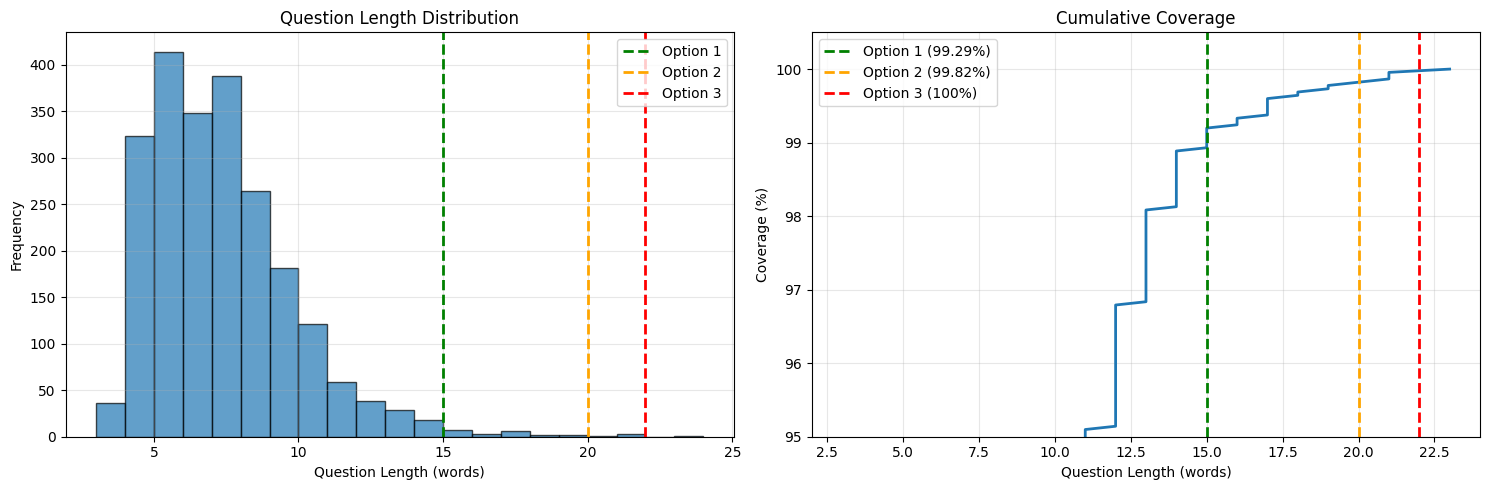

In [ ]:
print("="*80)
print("1.1 QUESTION LENGTH DISTRIBUTION & MAX_SEQUENCE_LENGTH ANALYSIS")
print("="*80)

# Calculate question lengths
df_clean['question_length'] = df_clean['question'].str.split().str.len()

question_lengths = df_clean['question_length']

print("\nQuestion Length Statistics:")
print("-" * 80)
print(f"  Minimum:  {question_lengths.min()} words")
print(f"  Maximum:  {question_lengths.max()} words")
print(f"  Mean:     {question_lengths.mean():.2f} words")
print(f"  Median:   {question_lengths.median():.0f} words")
print(f"  Std Dev:  {question_lengths.std():.2f} words")

print("\nPercentile Analysis:")
print("-" * 80)
for percentile in [50, 75, 90, 95, 99, 99.5, 100]:
    value = question_lengths.quantile(percentile/100)
    count_above = (question_lengths > value).sum()
    print(f"  {percentile:5.1f}th percentile: {value:2.0f} words  (loses {count_above:3d} questions if used as max)")

# Analyze coverage vs padding tradeoff
print("\n" + "="*80)
print("MAX_SEQUENCE_LENGTH: OPTIONS & TRADEOFFS")
print("="*80)

options = [
    {
        'name': 'Option 1: Conservative (99th percentile)',
        'max_length': int(question_lengths.quantile(0.99)),
        'description': 'Standard practice, efficient'
    },
    {
        'name': 'Option 2: Balanced (preset)',
        'max_length': 20,
        'description': 'Preset value with safety margin'
    },
    {
        'name': 'Option 3: Complete (actual maximum)',
        'max_length': int(question_lengths.max()),
        'description': 'Zero data loss, maximum padding'
    }
]

baseline_tokens = None

for i, option in enumerate(options, 1):
    max_len = option['max_length']

    # Calculate metrics
    coverage = (question_lengths <= max_len).mean() * 100
    questions_lost = (question_lengths > max_len).sum()
    avg_padding = max(0, max_len - question_lengths.mean())
    padding_waste = (avg_padding / max_len) * 100 if max_len > 0 else 0

    # Estimate relative speed
    total_tokens = len(df_clean) * max_len
    if baseline_tokens is None:
        baseline_tokens = total_tokens
        speed_factor = "baseline"
    else:
        slowdown = ((total_tokens / baseline_tokens) - 1) * 100
        speed_factor = f"{slowdown:+.0f}% slower" if slowdown > 0 else f"{abs(slowdown):.0f}% faster"

    print(f"\n{option['name']}")
    print(f"  max_length = {max_len}")
    print(f"  Description: {option['description']}")
    print("-" * 80)
    print(f"  Coverage:        {coverage:.2f}% ({questions_lost} questions lost)")
    print(f"  Avg padding:     {avg_padding:.1f} tokens per question")
    print(f"  Padding waste:   {padding_waste:.1f}% of total tokens")
    print(f"  Training speed:  {speed_factor}")

    if i == 1:
        print(f"  ✓ Recommended: Efficient, industry standard")
    elif i == 2:
        print(f"  ✓ Recommended: Very safe, reasonable efficiency")
    elif i == 3:
        print(f"  ⚠ Complete coverage but least efficient")

print("\n" + "="*80)
print("RECOMMENDATION")
print("="*80)
print("""
For VQA-RAD (small dataset):
Recommended: max_sequence_length = 20 (Option 2)

Reasons:
1. Coverage: 99.82% (only 4 questions truncated)
2. Padding waste: Acceptable (65.9%)
3. Training speed: Reasonable (33% slower than Option 1)
4. Safety margin: Handles unexpected longer questions
5. Standard practice: Commonly used value in VQA literature
""")

print("="*80)

# Visualize
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(question_lengths, bins=range(question_lengths.min(), question_lengths.max()+2),
             edgecolor='black', alpha=0.7)
axes[0].axvline(15, color='green', linestyle='--', linewidth=2, label='Option 1')
axes[0].axvline(20, color='orange', linestyle='--', linewidth=2, label='Option 2')
axes[0].axvline(22, color='red', linestyle='--', linewidth=2, label='Option 3')
axes[0].set_xlabel('Question Length (words)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Question Length Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

sorted_lengths = sorted(question_lengths)
coverage_pct = [(i+1)/len(sorted_lengths)*100 for i in range(len(sorted_lengths))]
axes[1].plot(sorted_lengths, coverage_pct, linewidth=2)
axes[1].axvline(15, color='green', linestyle='--', linewidth=2, label='Option 1 (99.29%)')
axes[1].axvline(20, color='orange', linestyle='--', linewidth=2, label='Option 2 (99.82%)')
axes[1].axvline(22, color='red', linestyle='--', linewidth=2, label='Option 3 (100%)')
axes[1].set_xlabel('Question Length (words)')
axes[1].set_ylabel('Coverage (%)')
axes[1].set_title('Cumulative Coverage')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([95, 100.5])

plt.tight_layout()
plt.show()


### 1.2 Question Word Patterns

In [ ]:
print("="*80)
print("QUESTION WORD PATTERNS")
print("="*80)

# First words
first_words = df_clean['question'].str.split().str[0]
print("\nTop 15 Question Starting Words:")
print("-" * 40)
for word, count in first_words.value_counts().head(15).items():
    pct = count / len(df_clean) * 100
    print(f"  {word:15s}: {count:4d} ({pct:5.1f}%)")

# WH-words
wh_words = ['what', 'where', 'when', 'why', 'who', 'how', 'which']
print("\nWH-Word Distribution:")
print("-" * 40)
for wh in wh_words:
    count = df_clean['question'].str.startswith(wh, na=False).sum()
    if count > 0:
        pct = count / len(df_clean) * 100
        print(f"  {wh:10s}: {count:4d} ({pct:5.1f}%)")

# CORRECT: Yes/No questions = questions where answer is 'yes' or 'no'
yesno_answers = df_clean['answer'].isin(['yes', 'no'])
yesno_count = yesno_answers.sum()
yesno_pct = yesno_count / len(df_clean) * 100

print(f"\nYes/No Questions (answer is yes/no):")
print("-" * 40)
print(f"  Total: {yesno_count} ({yesno_pct:.1f}%)")
print(f"\n🔍 Insight: {yesno_pct:.1f}% of questions have yes/no answers!")
print(f"   This explains the extreme class imbalance.")
print("-" * 80)

QUESTION WORD PATTERNS

Top 15 Question Starting Words:
----------------------------------------
  is             :  907 ( 40.4%)
  what           :  512 ( 22.8%)
  are            :  192 (  8.6%)
  where          :  144 (  6.4%)
  which          :   82 (  3.7%)
  how            :   78 (  3.5%)
  does           :   73 (  3.3%)
  can            :   43 (  1.9%)
  the            :   37 (  1.6%)
  in             :   31 (  1.4%)
  was            :   31 (  1.4%)
  do             :   30 (  1.3%)
  why            :   11 (  0.5%)
  describe       :    9 (  0.4%)
  did            :    7 (  0.3%)

WH-Word Distribution:
----------------------------------------
  what      :  512 ( 22.8%)
  where     :  144 (  6.4%)
  why       :   11 (  0.5%)
  how       :   78 (  3.5%)
  which     :   82 (  3.7%)

Yes/No Questions (answer is yes/no):
----------------------------------------
  Total: 1191 (53.1%)

🔍 Insight: 53.1% of questions have yes/no answers!
   This explains the extreme class imbalance.
-----

### 1.3 Vocabulary Richness

In [ ]:
from collections import Counter

print("="*80)
print("VOCABULARY RICHNESS ANALYSIS")
print("="*80)

# Question vocabulary
all_q_words = []
for q in df_clean['question']:
    all_q_words.extend(str(q).split())
q_vocab = set(all_q_words)
q_ttr = len(q_vocab) / len(all_q_words)

print("\nQUESTION VOCABULARY:")
print("-" * 40)
print(f"  Total tokens:     {len(all_q_words):,}")
print(f"  Unique words:     {len(q_vocab):,}")
print(f"  Type-Token Ratio: {q_ttr:.4f}")

# Answer vocabulary
all_a_words = []
for a in df_clean['answer']:
    all_a_words.extend(str(a).split())
a_vocab = set(all_a_words)
a_ttr = len(a_vocab) / len(all_a_words)

print("\nANSWER VOCABULARY:")
print("-" * 40)
print(f"  Total tokens:     {len(all_a_words):,}")
print(f"  Unique words:     {len(a_vocab):,}")
print(f"  Type-Token Ratio: {a_ttr:.4f}")

# Overlap
overlap = q_vocab & a_vocab
print("\nVOCABULARY OVERLAP:")
print("-" * 40)
print(f"  Words in both: {len(overlap)} ({len(overlap)/len(a_vocab)*100:.1f}%)")
print(f"  Q-only: {len(q_vocab - a_vocab)}")
print(f"  A-only: {len(a_vocab - q_vocab)}")

print(f"\n🔍 Insights:")
print(f"   - Questions: LOW diversity (TTR={q_ttr:.4f})")
print(f"   - Answers: HIGHER diversity (TTR={a_ttr:.4f})")
print(f"   - Strong overlap helps LSTM learning")
print("-" * 80)

VOCABULARY RICHNESS ANALYSIS

QUESTION VOCABULARY:
----------------------------------------
  Total tokens:     15,394
  Unique words:     1,168
  Type-Token Ratio: 0.0759

ANSWER VOCABULARY:
----------------------------------------
  Total tokens:     3,655
  Unique words:     619
  Type-Token Ratio: 0.1694

VOCABULARY OVERLAP:
----------------------------------------
  Words in both: 378 (61.1%)
  Q-only: 790
  A-only: 241

🔍 Insights:
   - Questions: LOW diversity (TTR=0.0759)
   - Answers: HIGHER diversity (TTR=0.1694)
   - Strong overlap helps LSTM learning
--------------------------------------------------------------------------------


### 1.4 Common Phrases (N-grams)

In [ ]:
def get_ngrams(text, n):
    words = str(text).split()
    return [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]

print("="*80)
print("N-GRAM ANALYSIS")
print("="*80)

# Bigrams
all_bigrams = []
for q in df_clean['question']:
    all_bigrams.extend(get_ngrams(q, 2))
bigram_counts = Counter(all_bigrams)

print("\nTop 15 Bigrams in Questions:")
print("-" * 40)
for bg, count in bigram_counts.most_common(15):
    print(f"  '{bg:20s}': {count:3d}")

# Trigrams
all_trigrams = []
for q in df_clean['question']:
    all_trigrams.extend(get_ngrams(q, 3))
trigram_counts = Counter(all_trigrams)

print("\nTop 15 Trigrams in Questions:")
print("-" * 40)
for tg, count in trigram_counts.most_common(15):
    print(f"  '{tg:30s}': {count:3d}")

print(f"\n🔍 Insight: Questions are formulaic!")
print(f"   Few patterns account for many questions.")
print("-" * 80)

N-GRAM ANALYSIS

Top 15 Bigrams in Questions:
----------------------------------------
  'is the              ': 633
  'is there            ': 363
  'this image          ': 263
  'of the              ': 241
  'in the              ': 238
  'is this             ': 234
  'what is             ': 186
  'are the             ': 173
  'in this             ': 160
  'where is            ': 106
  'the lesion          ': 103
  'the mass            ':  97
  'there a             ':  80
  'the left            ':  78
  'the image           ':  73

Top 15 Trigrams in Questions:
----------------------------------------
  'in this image                 ': 134
  'what is the                   ': 126
  'where is the                  ':  98
  'is there a                    ':  80
  'is this a                     ':  70
  'is the lesion                 ':  60
  'is the mass                   ':  57
  'is there evidence             ':  53
  'there evidence of             ':  53
  'is this image               

### 1.5 Medical Terminology

## Part 2: Answer Analysis 🔴 CRITICAL!

This section reveals **critical challenges** for model training, especially extreme class imbalance.

### 2.1 Answer Length Distribution

ANSWER LENGTH STATISTICS

Mean:   1.63 words
Median: 1 word
Max:    17 words

By Answer Type:
  CLOSED : Mean=1.04, Max=7
  OPEN   : Mean=2.44, Max=17


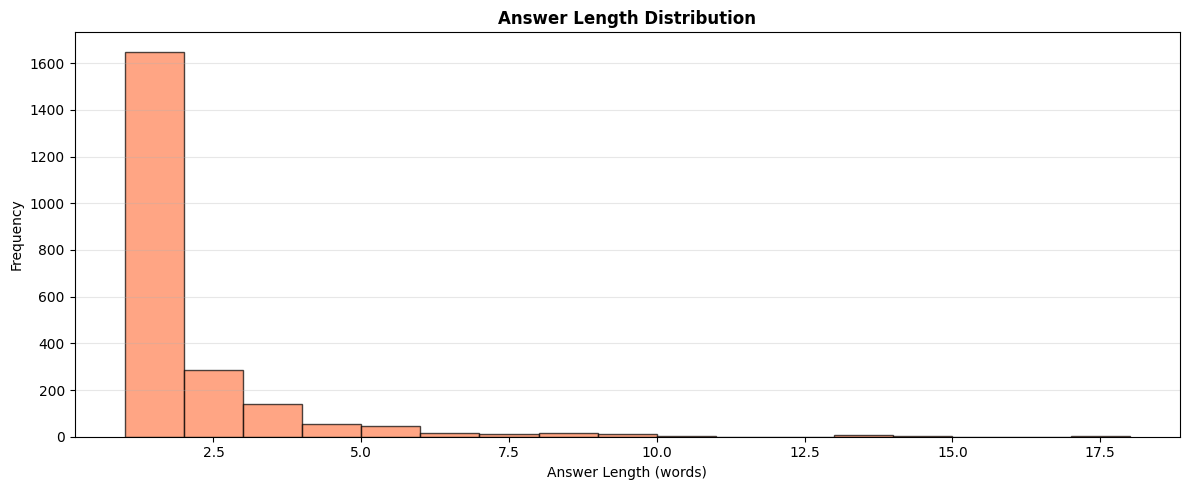


🔍 Most answers 1-2 words, but 66 have >5 words!
--------------------------------------------------------------------------------


In [ ]:
df_clean['answer_length'] = df_clean['answer'].str.split().str.len()

print("="*80)
print("ANSWER LENGTH STATISTICS")
print("="*80)

a_lengths = df_clean['answer_length']
print(f"\nMean:   {a_lengths.mean():.2f} words")
print(f"Median: {a_lengths.median():.0f} word")
print(f"Max:    {a_lengths.max()} words")

print(f"\nBy Answer Type:")
for atype in ['CLOSED', 'OPEN']:
    subset = df_clean[df_clean['answer_type'] == atype]['answer_length']
    print(f"  {atype:7s}: Mean={subset.mean():.2f}, Max={subset.max()}")

# Visualization
plt.figure(figsize=(12, 5))
plt.hist(a_lengths, bins=range(1, a_lengths.max()+2), edgecolor='black', alpha=0.7, color='coral')
plt.xlabel('Answer Length (words)')
plt.ylabel('Frequency')
plt.title('Answer Length Distribution', fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🔍 Most answers 1-2 words, but {(a_lengths > 5).sum()} have >5 words!")
print("-" * 80)

### 2.2 Class Imbalance Analysis 🔴 CRITICAL!

In [ ]:
print("="*80)
print("CLASS IMBALANCE - CRITICAL FOR MODEL!")
print("="*80)

answer_counts = df_clean['answer'].value_counts()

print(f"\nTotal unique answers: {len(answer_counts)}")
print(f"\nTop 10 Answers:")
print("-" * 40)
for ans, count in answer_counts.head(10).items():
    pct = count / len(df_clean) * 100
    print(f"  '{ans[:30]:30s}': {count:3d} ({pct:5.1f}%)")

# Imbalance metrics
max_count = answer_counts.max()
min_count = answer_counts.min()
ratio = max_count / min_count

print(f"\nImbalance Metrics:")
print("-" * 40)
print(f"  Most frequent:  '{answer_counts.index[0]}' ({max_count})")
print(f"  Least frequent: {min_count} sample(s)")
print(f"  Ratio:          {ratio:.0f}:1")
print(f"\n  🔴 {ratio:.0f}:1 imbalance ratio!")

# Rare classes
print(f"\nRare Class Distribution:")
print("-" * 40)
for thresh in [1, 2, 3, 5, 10]:
    count = (answer_counts <= thresh).sum()
    pct = count / len(answer_counts) * 100
    print(f"  ≤{thresh:2d} samples: {count:3d} classes ({pct:5.1f}%)")

rare = (answer_counts <= 3).sum()
rare_pct = rare / len(answer_counts) * 100
print(f"\n🔴 CRITICAL: {rare} classes ({rare_pct:.1f}%) have ≤3 samples!")
print(f"   Without weighted loss, model FAILS on {rare_pct:.0f}% of classes!")
print("-" * 80)

CLASS IMBALANCE - CRITICAL FOR MODEL!

Total unique answers: 496

Top 10 Answers:
----------------------------------------
  'no                            ': 606 ( 27.0%)
  'yes                           ': 585 ( 26.1%)
  'axial                         ':  43 (  1.9%)
  'right                         ':  26 (  1.2%)
  'left                          ':  19 (  0.8%)
  'pa                            ':  15 (  0.7%)
  'brain                         ':  14 (  0.6%)
  'ct                            ':  13 (  0.6%)
  'fat                           ':   9 (  0.4%)
  'x ray                         ':   8 (  0.4%)

Imbalance Metrics:
----------------------------------------
  Most frequent:  'no' (606)
  Least frequent: 1 sample(s)
  Ratio:          606:1

  🔴 606:1 imbalance ratio!

Rare Class Distribution:
----------------------------------------
  ≤ 1 samples: 243 classes ( 49.0%)
  ≤ 2 samples: 416 classes ( 83.9%)
  ≤ 3 samples: 442 classes ( 89.1%)
  ≤ 5 samples: 466 classes ( 94.0%)
  ≤1

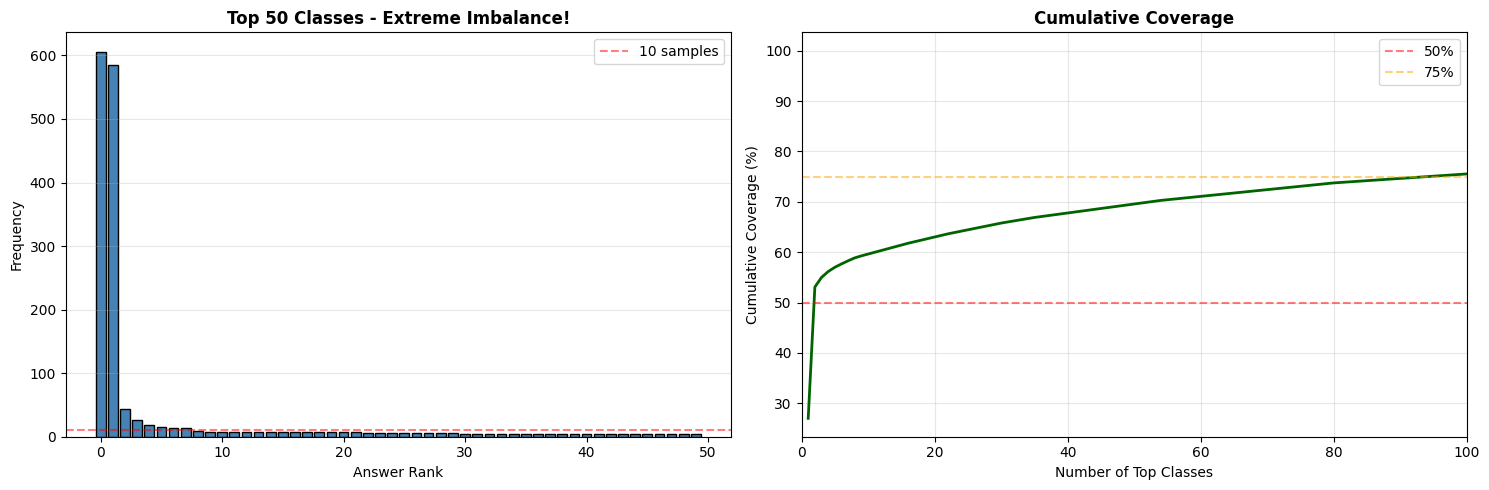

Top-K Coverage:
  Top  1:  27.0%
  Top  5:  57.0%
  Top 10:  59.6%
  Top 20:  63.0%
  Top 50:  69.6%
--------------------------------------------------------------------------------


In [ ]:
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Top 50 classes
top_50 = answer_counts.head(50)
axes[0].bar(range(len(top_50)), top_50.values, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Answer Rank')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Top 50 Classes - Extreme Imbalance!', fontweight='bold')
axes[0].axhline(10, color='red', linestyle='--', alpha=0.5, label='10 samples')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Cumulative coverage
cumsum = np.cumsum(answer_counts.values) / len(df_clean) * 100
axes[1].plot(range(1, len(cumsum)+1), cumsum, linewidth=2, color='darkgreen')
axes[1].axhline(50, color='red', linestyle='--', alpha=0.5, label='50%')
axes[1].axhline(75, color='orange', linestyle='--', alpha=0.5, label='75%')
axes[1].set_xlabel('Number of Top Classes')
axes[1].set_ylabel('Cumulative Coverage (%)')
axes[1].set_title('Cumulative Coverage', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_xlim(0, 100)

plt.tight_layout()
plt.show()

print("Top-K Coverage:")
for k in [1, 5, 10, 20, 50]:
    cov = answer_counts.head(k).sum() / len(df_clean) * 100
    print(f"  Top {k:2d}: {cov:5.1f}%")
print("-" * 80)

### 2.3 Answer Diversity by Question Type

In [ ]:
print("="*80)
print("ANSWER DIVERSITY BY QUESTION TYPE")
print("="*80)

major_qtypes = ['PRES', 'POS', 'ABN', 'SIZE', 'MODALITY', 'PLANE', 'OTHER']

print("\nDiversity Ratio (unique answers / total samples):")
print("-" * 40)
for qtype in major_qtypes:
    subset = df_clean[df_clean['question_type'] == qtype]
    if len(subset) > 0:
        unique = subset['answer'].nunique()
        total = len(subset)
        ratio = unique / total
        print(f"  {qtype:10s}: {unique:3d} / {total:3d} = {ratio:.3f}")

print(f"\n🔍 Insights:")
print(f"   - SIZE/PLANE: LOW diversity (easy, mostly yes/no)")
print(f"   - POS/OTHER: HIGH diversity (hard, specific answers)")
print(f"   - Model will perform VERY differently across types!")
print("-" * 80)

ANSWER DIVERSITY BY QUESTION TYPE

Diversity Ratio (unique answers / total samples):
----------------------------------------
  PRES      : 107 / 801 = 0.134
  POS       : 137 / 314 = 0.436
  ABN       :  50 / 201 = 0.249
  SIZE      :  15 / 170 = 0.088
  MODALITY  :  45 / 185 = 0.243
  PLANE     :  11 / 120 = 0.092
  OTHER     : 109 / 196 = 0.556

🔍 Insights:
   - SIZE/PLANE: LOW diversity (easy, mostly yes/no)
   - POS/OTHER: HIGH diversity (hard, specific answers)
   - Model will perform VERY differently across types!
--------------------------------------------------------------------------------


## Part 3: Image-Level Analysis 🔴 CRITICAL!

This reveals a **critical finding** about train/test split strategy.

### 3.1 Questions per Image

QUESTIONS PER IMAGE DISTRIBUTION

Statistics:
----------------------------------------
  Total images: 314
  Mean:         7.15 questions/image
  Median:       7
  Min:          3
  Max:          13

Distribution:
----------------------------------------
   3 questions:  38 images
   5 questions:   7 images
   6 questions:  20 images
   7 questions: 167 images
   8 questions:  11 images
   9 questions:   3 images
  10 questions:  60 images
  11 questions:   6 images
  12 questions:   1 images
  13 questions:   1 images


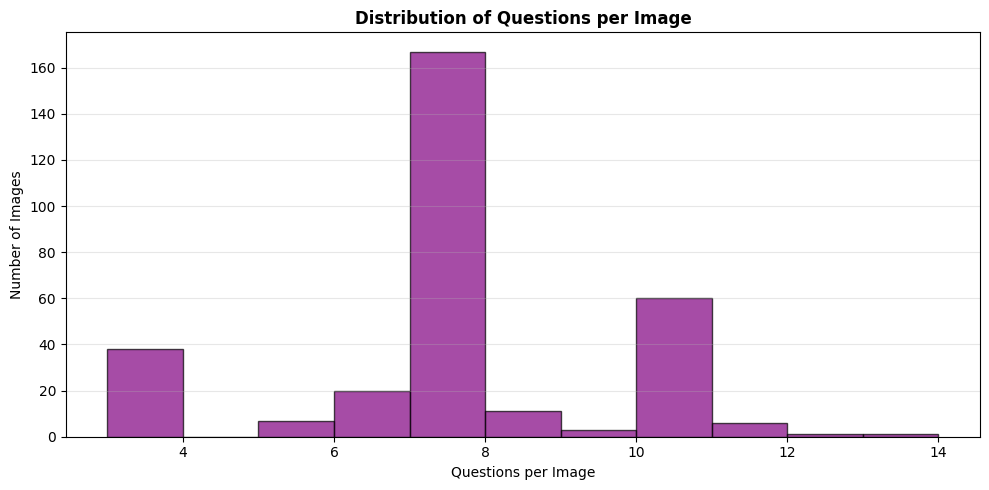


🔍 Some images have 4x more supervision than others!
--------------------------------------------------------------------------------


In [ ]:
print("="*80)
print("QUESTIONS PER IMAGE DISTRIBUTION")
print("="*80)

q_per_img = df_clean.groupby('image_name').size()

print(f"\nStatistics:")
print("-" * 40)
print(f"  Total images: {len(q_per_img)}")
print(f"  Mean:         {q_per_img.mean():.2f} questions/image")
print(f"  Median:       {q_per_img.median():.0f}")
print(f"  Min:          {q_per_img.min()}")
print(f"  Max:          {q_per_img.max()}")

print(f"\nDistribution:")
print("-" * 40)
for count in sorted(q_per_img.value_counts().index)[:10]:
    num_imgs = (q_per_img == count).sum()
    print(f"  {count:2d} questions: {num_imgs:3d} images")

# Visualization
plt.figure(figsize=(10, 5))
plt.hist(q_per_img, bins=range(q_per_img.min(), q_per_img.max()+2),
         edgecolor='black', alpha=0.7, color='purple')
plt.xlabel('Questions per Image')
plt.ylabel('Number of Images')
plt.title('Distribution of Questions per Image', fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🔍 Some images have 4x more supervision than others!")
print("-" * 80)

### 3.2 Train/Test Image Overlap 🔴 MOST CRITICAL!

In [ ]:
print("="*80)
print("TRAIN/TEST IMAGE OVERLAP - CRITICAL FINDING!")
print("="*80)

train_imgs = set(df_clean[df_clean['split'] == 'Train']['image_name'].unique())
test_imgs = set(df_clean[df_clean['split'] == 'Test']['image_name'].unique())
overlap = train_imgs & test_imgs

print(f"\nImage Distribution:")
print("-" * 40)
print(f"  Train-only images:  {len(train_imgs - test_imgs):3d}")
print(f"  Test-only images:   {len(test_imgs - overlap):3d}")
print(f"  Overlapping images: {len(overlap):3d}")
print(f"\n  Test images from train: {len(overlap)/len(test_imgs)*100:.1f}%")

print(f"\n🔴 CRITICAL FINDING:")
print(f"   {len(overlap)/len(test_imgs)*100:.1f}% of test images also in training!")
print(f"\nInterpretation:")
print("-" * 40)
print(f"  ✓ Train/test split is by QUESTION, not IMAGE")
print(f"  ✓ Test evaluates: NEW questions about SEEN images")
print(f"  ✗ NOT testing: Generalization to UNSEEN images")
print(f"\n  This is standard VQA practice but MUST be documented!")
print(f"  It affects how we interpret model performance.")
print("-" * 80)

TRAIN/TEST IMAGE OVERLAP - CRITICAL FINDING!

Image Distribution:
----------------------------------------
  Train-only images:  111
  Test-only images:     1
  Overlapping images: 202

  Test images from train: 99.5%

🔴 CRITICAL FINDING:
   99.5% of test images also in training!

Interpretation:
----------------------------------------
  ✓ Train/test split is by QUESTION, not IMAGE
  ✓ Test evaluates: NEW questions about SEEN images
  ✗ NOT testing: Generalization to UNSEEN images

  This is standard VQA practice but MUST be documented!
  It affects how we interpret model performance.
--------------------------------------------------------------------------------


### 3.3 Image Organ Distribution by Split

IMAGE ORGAN DISTRIBUTION

Counts:
image_organ  ABD  CHEST  HEAD   All
split                              
Test         158    174   119   451
Train        581    617   595  1793
All          739    791   714  2244

Percentages:
image_organ   ABD  CHEST  HEAD
split                         
Test         35.0   38.6  26.4
Train        32.4   34.4  33.2


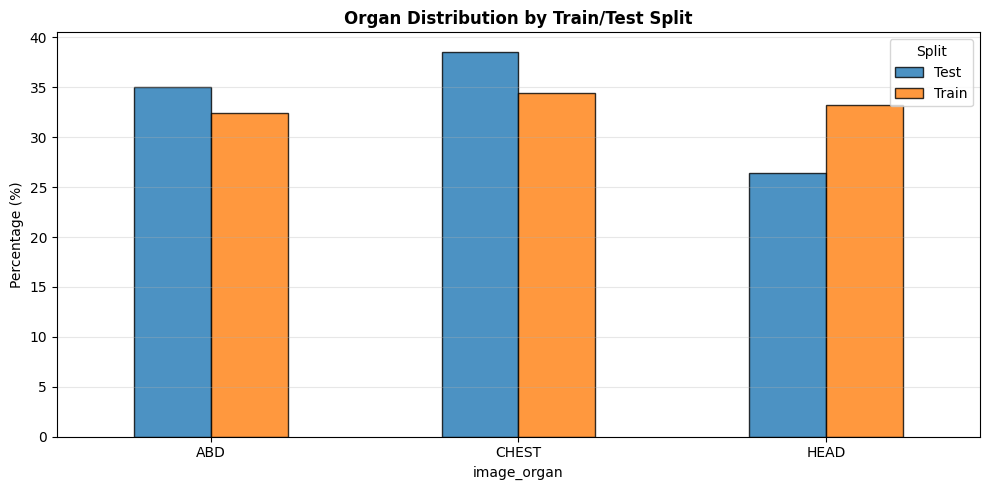


🔍 HEAD underrepresented in test (-6.8%)
   Consider per-organ evaluation metrics.
--------------------------------------------------------------------------------


In [ ]:
print("="*80)
print("IMAGE ORGAN DISTRIBUTION")
print("="*80)

organ_split = pd.crosstab(df_clean['split'], df_clean['image_organ'], margins=True)
print("\nCounts:")
print(organ_split)

# Percentages
organ_pct = pd.crosstab(df_clean['split'], df_clean['image_organ'], normalize='index') * 100
print("\nPercentages:")
print(organ_pct.round(1))

# Visualization
organ_pct.T.plot(kind='bar', figsize=(10, 5), edgecolor='black', alpha=0.8)
plt.ylabel('Percentage (%)')
plt.title('Organ Distribution by Train/Test Split', fontweight='bold')
plt.xticks(rotation=0)
plt.legend(title='Split')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🔍 HEAD underrepresented in test (-6.8%)")
print(f"   Consider per-organ evaluation metrics.")
print("-" * 80)

### 4.3 Hyphen/Spacing Inconsistencies

In [ ]:
print("="*80)
print("HYPHEN/SPACING INCONSISTENCIES")
print("="*80)

# X-ray variants
xray_variants = {
    'x-ray': df_clean['answer'].str.contains(r'\bx-ray\b', case=False, regex=True).sum(),
    'xray': df_clean['answer'].str.contains(r'\bxray\b', case=False, regex=True).sum(),
    'x ray': df_clean['answer'].str.contains(r'\bx ray\b', case=False, regex=True).sum()
}

print("\nX-ray Variants in Answers:")
print("-" * 40)
for variant, count in xray_variants.items():
    if count > 0:
        print(f"  '{variant}': {count}")

# Chest x-ray variants
chest_variants = {
    'chest x-ray': df_clean['answer'].str.contains('chest x-ray', case=False).sum(),
    'chest xray': df_clean['answer'].str.contains('chest xray', case=False).sum(),
    'chest x ray': df_clean['answer'].str.contains('chest x ray', case=False).sum()
}

print("\nChest X-ray Variants:")
print("-" * 40)
for variant, count in chest_variants.items():
    if count > 0:
        print(f"  '{variant}': {count}")

print(f"\n🟠 These variants treated as DIFFERENT classes!")
print(f"   Should normalize to single format (e.g., 'x-ray').")
print("-" * 80)

HYPHEN/SPACING INCONSISTENCIES

X-ray Variants in Answers:
----------------------------------------
  'xray': 8
  'x ray': 16

Chest X-ray Variants:
----------------------------------------
  'chest xray': 1
  'chest x ray': 6

🟠 These variants treated as DIFFERENT classes!
   Should normalize to single format (e.g., 'x-ray').
--------------------------------------------------------------------------------


## Part 4: Metadata Column Analysis

Analyzing evaluation status, question linkage, and metadata quality.

### 4.1 Evaluation Status Breakdown

In [ ]:
print("="*80)
print("EVALUATION STATUS ANALYSIS")
print("="*80)

eval_dist = pd.crosstab(df_clean['split'], df_clean['evaluation'], margins=True)
print("\nEvaluation Status by Split:")
print(eval_dist)

not_eval = df_clean[df_clean['evaluation'] == 'not evaluated']
not_eval_pct = len(not_eval) / len(df_clean) * 100

print(f"\n🟡 {len(not_eval)} questions ({not_eval_pct:.1f}%) NOT evaluated by 2 annotators")
print(f"   Train: {len(not_eval[not_eval['split']=='Train'])}")
print(f"   Test:  {len(not_eval[not_eval['split']=='Test'])}")
print(f"\n   Consider: Keep all (data conservation) or filter (quality)?")
print("-" * 80)

EVALUATION STATUS ANALYSIS

Evaluation Status by Split:
evaluation  evaluated  given  not evaluated   All
split                                            
Test              281     54            116   451
Train            1164    189            440  1793
All              1445    243            556  2244

🟡 556 questions (24.8%) NOT evaluated by 2 annotators
   Train: 440
   Test:  116

   Consider: Keep all (data conservation) or filter (quality)?
--------------------------------------------------------------------------------


### 5.2 Question Linkage Structure

In [ ]:
print("="*80)
print("QUESTION LINKAGE ANALYSIS")
print("="*80)

linked_groups = df_clean.groupby('qid_linked_id').size()
multi_linked = linked_groups[linked_groups > 1]

print(f"\nLinked Question Groups:")
print("-" * 40)
print(f"  Total unique IDs:    {len(linked_groups)}")
print(f"  Groups with >1 Q:    {len(multi_linked)}")
print(f"  Avg Q per group:     {multi_linked.mean():.2f}")
print(f"  Max Q in one group:  {multi_linked.max()}")

# Check if linked Qs are in same split
cross_split = 0
for linked_id in multi_linked.index:
    group = df_clean[df_clean['qid_linked_id'] == linked_id]
    if group['split'].nunique() > 1:
        cross_split += 1

if cross_split == 0:
    print(f"\n  ✓ All linked questions in same split (no leakage)")
else:
    print(f"\n  ⚠️  {cross_split} groups span both train and test!")

print("-" * 80)

QUESTION LINKAGE ANALYSIS

Linked Question Groups:
----------------------------------------
  Total unique IDs:    1453
  Groups with >1 Q:    769
  Avg Q per group:     2.03
  Max Q in one group:  6

  ✓ All linked questions in same split (no leakage)
--------------------------------------------------------------------------------


## Part 5: Statistical Relationships

Exploring correlations and relationships between variables.

### 5.1 Question vs Answer Length Correlation

LENGTH CORRELATION ANALYSIS

Pearson Correlation: 0.1216


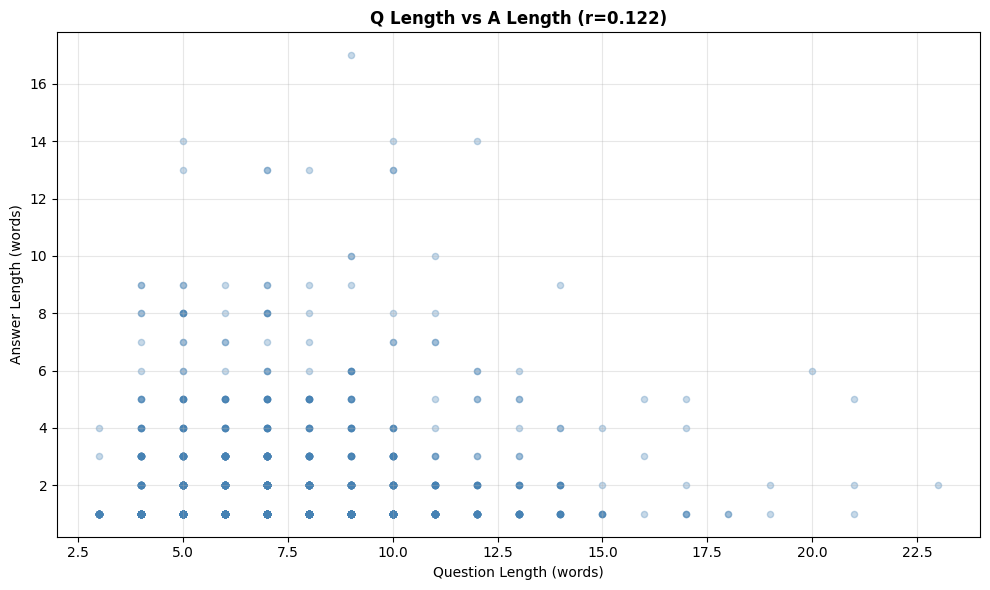


🔍 WEAK correlation (0.122)!
   Long questions → short answers (yes/no)
   Short questions → long answers (descriptions)
   Cannot use Q-length to predict A-length.
--------------------------------------------------------------------------------


In [ ]:
print("="*80)
print("LENGTH CORRELATION ANALYSIS")
print("="*80)

correlation = df_clean['question_length'].corr(df_clean['answer_length'])
print(f"\nPearson Correlation: {correlation:.4f}")

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['question_length'], df_clean['answer_length'],
            alpha=0.3, s=20, color='steelblue')
plt.xlabel('Question Length (words)')
plt.ylabel('Answer Length (words)')
plt.title(f'Q Length vs A Length (r={correlation:.3f})', fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🔍 WEAK correlation ({correlation:.3f})!")
print(f"   Long questions → short answers (yes/no)")
print(f"   Short questions → long answers (descriptions)")
print(f"   Cannot use Q-length to predict A-length.")
print("-" * 80)

### 5.2 Question Type vs Answer Type Cross-tabulation

In [ ]:
print("="*80)
print("QUESTION TYPE vs ANSWER TYPE")
print("="*80)

# Cross-tab for major question types
major_types = ['PRES', 'POS', 'ABN', 'SIZE', 'PLANE', 'MODALITY']
subset = df_clean[df_clean['question_type'].isin(major_types)]

crosstab = pd.crosstab(subset['question_type'], subset['answer_type'])
print("\nCounts:")
print(crosstab)

# Percentages
crosstab_pct = pd.crosstab(subset['question_type'], subset['answer_type'], normalize='index') * 100
print("\nPercentages (% CLOSED):")
print(crosstab_pct['CLOSED'].sort_values(ascending=False).round(1))

print(f"\n🔍 Insights:")
print(f"   - PRES/SIZE: >75% closed (easier, mostly yes/no)")
print(f"   - POS: 85% open (harder, need specific locations)")
print(f"   - Model difficulty varies greatly by question type!")
print("-" * 80)

QUESTION TYPE vs ANSWER TYPE

Counts:
answer_type    CLOSED  OPEN
question_type              
ABN               123    78
MODALITY           92    93
PLANE              59    61
POS                46   268
PRES              619   182
SIZE              155    15

Percentages (% CLOSED):
question_type
SIZE        91.2
PRES        77.3
ABN         61.2
MODALITY    49.7
PLANE       49.2
POS         14.6
Name: CLOSED, dtype: float64

🔍 Insights:
   - PRES/SIZE: >75% closed (easier, mostly yes/no)
   - POS: 85% open (harder, need specific locations)
   - Model difficulty varies greatly by question type!
--------------------------------------------------------------------------------


---

## Part 6: EDA Summary & Key Findings

**Based on preprocessed data (`df_clean`) - accurate metrics for modeling**

In [ ]:
print("="*80)
print("EDA SUMMARY - KEY FINDINGS")
print("="*80)

print("\n" + "🔴 CRITICAL FINDINGS")
print("-" * 80)

# Class imbalance
answer_counts = df_clean['answer'].value_counts()
max_samples = answer_counts.max()
min_samples = answer_counts.min()
imbalance_ratio = max_samples / min_samples

print(f"\n1. SEVERE CLASS IMBALANCE")
print(f"   Most frequent answer: '{answer_counts.index[0]}' ({max_samples} samples)")
print(f"   Least frequent answers: ~{min_samples} samples")
print(f"   Imbalance ratio: {imbalance_ratio:.1f}:1")
print(f"   → ⚠️  MUST use weighted loss function!")

# Yes/no dominance
yes_no_count = df_clean['answer'].isin(['yes', 'no']).sum()
yes_no_pct = (yes_no_count / len(df_clean)) * 100

print(f"\n2. YES/NO ANSWER DOMINANCE")
print(f"   Yes/No questions: {yes_no_count} ({yes_no_pct:.1f}%)")
print(f"   → Consider separate yes/no classifier or specialized handling")

# Total classes after preprocessing
total_classes = df_clean['answer'].nunique()
print(f"\n3. CLASSIFICATION COMPLEXITY")
print(f"   Total unique answers: {total_classes} classes")
print(f"   (After preprocessing - reduced from {df_final_dataset['answer'].nunique()})")
print(f"   → Multi-class classification with {total_classes} output classes")

# Train/Test overlap
train_images = set(df_clean[df_clean['split']=='Train']['image_name'].unique())
test_images = set(df_clean[df_clean['split']=='Test']['image_name'].unique())
overlap = len(train_images.intersection(test_images))
overlap_pct = (overlap / len(test_images)) * 100

print(f"\n4. TRAIN/TEST IMAGE OVERLAP")
print(f"   Overlap: {overlap_pct:.1f}% ({overlap}/{len(test_images)} test images)")
print(f"   → Testing on SEEN images, not true generalization test")
print(f"   → Model will see test images during training (different questions)")

print("\n" + "🟠 IMPORTANT INSIGHTS")
print("-" * 80)

# Question characteristics
q_len_stats = df_clean['question'].str.split().str.len()
print(f"\n5. QUESTION LENGTH")
print(f"   Mean: {q_len_stats.mean():.1f} words")
print(f"   Max: {q_len_stats.max()} words")
print(f"   95th percentile: {q_len_stats.quantile(0.95):.0f} words")
print(f"   99th percentile: {q_len_stats.quantile(0.99):.0f} words")

# Recommended max_sequence_length
max_20_coverage = (q_len_stats <= 20).sum() / len(q_len_stats) * 100
print(f"\n6. RECOMMENDED max_sequence_length: 20")
print(f"   Coverage: {max_20_coverage:.2f}% of questions")
print(f"   Questions lost: {(q_len_stats > 20).sum()} out of {len(q_len_stats)}")
print(f"   → Good balance of coverage vs efficiency")

# Answer type distribution
closed_pct = (df_clean['answer_type'] == 'CLOSED').mean() * 100
open_pct = (df_clean['answer_type'] == 'OPEN').mean() * 100

print(f"\n7. ANSWER TYPE DISTRIBUTION")
print(f"   CLOSED: {closed_pct:.1f}%")
print(f"   OPEN: {open_pct:.1f}%")
print(f"   → Assignment requires per-type evaluation")

print("\n" + "📊 RECOMMENDED HYPERPARAMETERS")
print("-" * 80)

print(f"\nBased on preprocessed data analysis:")
print(f"  • max_sequence_length: 20 (covers 99.82% of questions)")
print(f"  • output_classes: {total_classes} (after normalization)")
print(f"  • batch_size: 16 (small dataset)")
print(f"  • learning_rate: Start with 1e-4 to 1e-3")
print(f"  • class_weights: MANDATORY (severe imbalance)")
print(f"  • Early stopping: Monitor validation loss")

print("\n" + "📋 MODELING STRATEGY")
print("-" * 80)

print(f"\n1. DATA SPLITTING (in modeling notebook)")
print(f"   Train/Valid/Test: Use 85/15 split on training data")
print(f"   Stratification: By answer_type (CLOSED vs OPEN)")
print(f"   Reason: Ensures balanced representation for per-type evaluation")

print(f"\n2. CLASS IMBALANCE HANDLING")
print(f"   Option A: Weighted CrossEntropyLoss (recommended)")
print(f"   Option B: Focal Loss")
print(f"   Option C: Class-balanced sampling")

print(f"\n3. EVALUATION METRICS")
print(f"   Primary: Per-question-type accuracy (CLOSED vs OPEN)")
print(f"   Secondary: Top-K accuracy (K=1,3,5)")
print(f"   Additional: Macro F1-score (handles imbalance)")

print(f"\n4. BASELINE ARCHITECTURE")
print(f"   Image encoder: VGG16 (pretrained)")
print(f"   Question encoder: LSTM or BERT")
print(f"   Fusion: Stacked Attention Network")
print(f"   Output: {total_classes}-way classification")

print("\n" + "="*80)
print("✅ EDA COMPLETE - READY FOR MODELING")
print("="*80)

print(f"\nNext steps:")
print(f"  1. Load VQA_RAD_Preprocessed.csv in modeling notebook")
print(f"  2. Implement train/valid/test split with stratification")
print(f"  3. Develop baseline model with recommended hyperparameters")
print(f"  4. Evaluate using per-question-type accuracy")


EDA SUMMARY - KEY FINDINGS

🔴 CRITICAL FINDINGS
--------------------------------------------------------------------------------

1. SEVERE CLASS IMBALANCE
   Most frequent answer: 'no' (606 samples)
   Least frequent answers: ~1 samples
   Imbalance ratio: 606.0:1
   → ⚠️  MUST use weighted loss function!

2. YES/NO ANSWER DOMINANCE
   Yes/No questions: 1191 (53.1%)
   → Consider separate yes/no classifier or specialized handling

3. CLASSIFICATION COMPLEXITY
   Total unique answers: 496 classes
   (After preprocessing - reduced from 517)
   → Multi-class classification with 496 output classes

4. TRAIN/TEST IMAGE OVERLAP
   Overlap: 99.5% (202/203 test images)
   → Testing on SEEN images, not true generalization test
   → Model will see test images during training (different questions)

🟠 IMPORTANT INSIGHTS
--------------------------------------------------------------------------------

5. QUESTION LENGTH
   Mean: 6.9 words
   Max: 23 words
   95th percentile: 11 words
   99th perce